In [1]:
import os

from driftCorrection.reader_functions import read_bruker
from driftCorrection.scan_functions import (
    correct_background,
    correct_sensor,
    estimate_tip_velocity,
    extract_peaks,
    interpolate_multiple_scans,
    interpolate_scan,
    estimate_drift_from_cc
)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import numpy.matlib 
import scipy 
import skimage
import pickle
from scipy.spatial import Voronoi, voronoi_plot_2d
import glob

In [3]:
rc_params = {
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'figure.facecolor': 'white',
    'font.size': 16,
    'axes.labelsize': 16,
    'legend.title_fontsize': 16,
    'axes.linewidth': 1.5,
    'xtick.major.size': 5,
    'xtick.major.width': 1.5,
    'xtick.minor.size': 2.5,
    'xtick.minor.width': 1.5,
    'ytick.major.size': 5,
    'ytick.major.width': 1.5,
    'ytick.minor.size': 2.5,
    'ytick.minor.width': 1.5,
    'lines.linewidth': 2.5,
    'figure.figsize': [3*1.618, 3]
}
plt.rcParams.update(rc_params)

# Loading in data

Run this first cell every time.

Note: you need to have some folder called "data" in the root folder where you have this script
for everything to work correctly. You can of course add in another working path, but I find 
that this is mildly annoying me when I switch between Mac and PC, so I've been doing it this way.

Other important note: this set of scripts loads in the data such that the y-axis is the first
axis and the x-axis the second axis. This is a 90° CCW rotation from the way that it appears
in the Bruker Icon software! 

In [4]:
# get the current working directory 
FOLDER_ROOT = os.path.abspath(os.getcwd())



# You can pick and choose the channels you load in. Take an FFT
# in Gwyddion first to decide which ones have the best signal.
# For a 512 x 512 file, it usually takes 20-30 s to load in a single
# channel. This scales with file size, so some very large files 
# (think like a 4096 x 4096 scan) can take ~10 min per channel that
# you load in. I typically only load in the trace/retrace for phase. 
CHANNEL_NAMES = ["TR Phase: Trace", "TR Phase: Retrace", 
                 "TR Amplitude: Trace", "TR Amplitude: Retrace"] 
folder_name = "rpl_8" # change this each time

data_root = os.path.join(FOLDER_ROOT, "data",folder_name)
scan_names = [x.split('/')[-1] for x in glob.glob(f'{data_root}/*.spm')]
print(scan_names)

scan_number = []
for scan_name in scan_names:
    scan_number.append(int(scan_name.split('.')[-2]))
sorted_scans = np.array(sorted(scan_number))

sorted_scan_names = []
for number in sorted_scans:
    sorted_scan_names.append(np.array(scan_names, dtype = 'object')[scan_number == number][0])

scan_names = np.array(sorted_scan_names)
print(scan_names)



['RPL_8_TFM_15nm.0_00003.spm', 'RPL_8_TFM_15nm.0_00002.spm']
['RPL_8_TFM_15nm.0_00002.spm' 'RPL_8_TFM_15nm.0_00003.spm']


Run once for conversion to pickle. Once you have done it once, skip to the next cell next time you want to work with your data.

In [4]:
white_list = [x for x in range(112, 118,1)]
scans = []

for scan_name in scan_names:
    print(f'Processing {scan_name}')
    scan_path = os.path.join(data_root, scan_name)
    current_scan = read_bruker(scan_path)
    current_scan = correct_background(current_scan, channel_names=CHANNEL_NAMES)
    current_scan = correct_sensor(current_scan)
    current_scan = interpolate_scan(current_scan, channel_names=CHANNEL_NAMES)
    scans.append(current_scan)
    pickle_name = scan_name.replace('.spm', '.pkl')
    save_path = f'Processed/{pickle_name}'

    with open(save_path, "wb") as f:
        pickle.dump(current_scan, f)

Processing RPL_8_TFM_15nm.0_00002.spm
Processing RPL_8_TFM_15nm.0_00003.spm


Load from pickle. Run this every time (except from first time, though it wouldn't hurt.)

In [5]:
white_list = [x for x in range(108, 110,1)]
scans = []

for scan_name in scan_names:
    scan_name = scan_name.replace('.spm', '.pkl')
    file_path = f'Processed/{scan_name}'
    with open(file_path, 'rb') as f:
        current_scan = pickle.load(f)
    scans.append(current_scan)
    print(f'{scan_name} loaded')


print(scans)

RPL_8_TFM_15nm.0_00002.pkl loaded
RPL_8_TFM_15nm.0_00003.pkl loaded
[Scan(name=/Users/risa/Scripts/GitRepositories/MoireAnalysis/data/rpl_8/RPL_8_TFM_15nm.0_00002.spm, channels={'Xsensor: Retrace': Channel(name=Xsensor: Retrace), 'Ysensor: Retrace': Channel(name=Ysensor: Retrace), 'TR Amplitude: Retrace': Channel(name=TR Amplitude: Retrace), 'TR Phase: Retrace': Channel(name=TR Phase: Retrace), 'Xsensor: Trace': Channel(name=Xsensor: Trace), 'Ysensor: Trace': Channel(name=Ysensor: Trace), 'TR Amplitude: Trace': Channel(name=TR Amplitude: Trace), 'TR Phase: Trace': Channel(name=TR Phase: Trace)}), Scan(name=/Users/risa/Scripts/GitRepositories/MoireAnalysis/data/rpl_8/RPL_8_TFM_15nm.0_00003.spm, channels={'Xsensor: Retrace': Channel(name=Xsensor: Retrace), 'Ysensor: Retrace': Channel(name=Ysensor: Retrace), 'TR Amplitude: Retrace': Channel(name=TR Amplitude: Retrace), 'TR Phase: Retrace': Channel(name=TR Phase: Retrace), 'Xsensor: Trace': Channel(name=Xsensor: Trace), 'Ysensor: Trace': C

In [45]:
def moire_wavelength(theta, a=0.246):
    # assumes graphene lattice vector in nm
    return a/(2*np.sin(theta*2*np.pi/360/2))

def wavelength_to_angle(lambd, a=0.246):
    # assumes graphene lattice vector in nm
    return np.arcsin(a/(2*lambd))*360/np.pi

def plot_data(scan, channel = 'TR Phase', line_dir = 'Trace', 
              xy_range = 100, vlim = 5, save_fig = False):
    """
    Plot corrected scan data.

    scan = scan
    channel = 'TR Phase' or 'TR Amplitude'
    line_dir = 'Trace' or 'Retrace'
    xy_range = float, plotting range for x and y
    vlim = max value for colormap scale
    save_fig = bool, default False
    """
    
    units = {'TR Amplitude' : '(mV)', 'TR Phase' : '(°)'}
    
    # set up keys for extracting data
    data_channel = f'{channel}: {line_dir}'
    scan_number = int(scan.name.split('.')[-2])

    # pull out sensor data
    x_sensor = scan.channels[f'Xsensor: {line_dir}'].data
    y_sensor = scan.channels[f'Ysensor: {line_dir}'].data
    input_data = scan.channels[data_channel].data

    # print size of scan in length and in pix 
    print(f'Scan Size (X, Y): {scan.channels[data_channel].scan_size}, input data shape: {input_data.shape}')

    # fig, ax = plt.subplots(figsize=(4,4), layout='constrained')
    fig = plt.figure(figsize=(4,4))
    gs = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.95, hspace=0.02, wspace=0.1, width_ratios=[1, 0.1])
    ax = fig.add_subplot(gs[0])
    cax = fig.add_subplot(gs[1])

    # x and y are shifted so that their central value is at zero
    data_plot = ax.pcolormesh(x_sensor-np.average(x_sensor), y_sensor-np.average(y_sensor), input_data, \
                              cmap = 'inferno', vmin = -vlim, vmax = vlim, rasterized = True)
    plt.colorbar(data_plot, cax=cax, orientation='vertical').set_label(f'{channel} {units[channel]}')

    # figure formatting
    ax.set_aspect('equal')
    ax.set_title(f'Scan {scan_number}')
    ax.set_xlabel('X (nm)')
    ax.set_ylabel('Y (nm)')
    ax.set_xlim(-xy_range/2, xy_range/2)
    ax.set_ylim(-xy_range/2, xy_range/2)
    ax.set_xticks([-xy_range/2, 0, xy_range/2])
    ax.set_yticks([-xy_range/2, 0, xy_range/2])

    if save_fig:
        fig.savefig(f'Scan_{number}_{channel}.jpeg', dpi = 400, bbox_inches = 'tight')



Scan Size (X, Y): (13.389545960323403, 14.838727056289088), input data shape: (512, 512)
Scan Size (X, Y): (13.417523579966655, 14.73438329128021), input data shape: (512, 512)


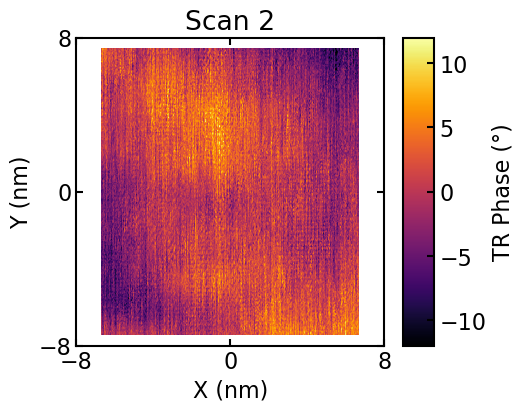

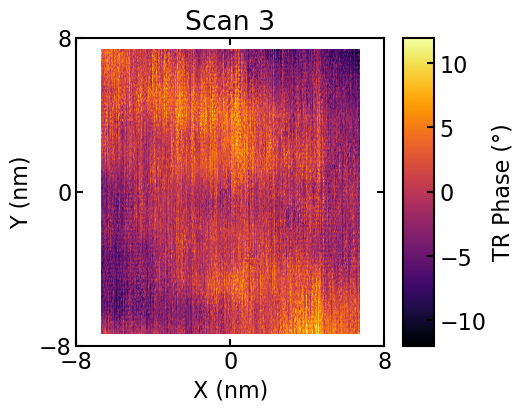

In [7]:
data_channels = ['TR Phase']
line_dir = 'Trace'
vlimits = {'TR Amplitude' : 12, 'TR Phase' : 12}

for scan in scans:
    for channel in data_channels:
        plot_data(scan, channel, line_dir = line_dir, vlim = vlimits[channel], xy_range = 16)


# Fitting atomic lattice orientation

## Fitting code for atomic lattice

In [27]:
def find_fourier_peaks(input_data, peak_threshold = 0.1, window_size = (1,1), 
                               padding = 1, plot = False, kxky_range = 5, vlim = 0.5):  
    sy, sx = input_data.shape
    hanning_window = np.sqrt(np.outer(scipy.signal.windows.hann(sy), scipy.signal.windows.hann(sx)))   
    windowed_data = np.pad(np.multiply(input_data, hanning_window), [(sy * padding, sy * padding), (sx * padding, sx * padding)])
    nonwindowed_data = np.pad(input_data, [(sy * padding, sy * padding), (sx * padding, sx * paddindg)])
    window_fft = np.abs(scipy.fft.fftshift(scipy.fft.fft2(windowed_data)))
    fft = np.abs(scipy.fft.fftshift(scipy.fft.fft2(nonwindowed_data)))

    PSD = window_fft**2
    PSD = PSD/np.amax(PSD)

    lx, ly = window_size
    scalex = lx * len(nonwindowed_data.T) / sx # nm
    scaley = ly * len(nonwindowed_data) / sy # nm
    xs = np.linspace(-len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T), endpoint = False)
    ys = np.linspace(-len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data), endpoint = False)

    fig, ax = plt.subplots(1,1, figsize = (4,4))
    ax.set_aspect('equal')
    display_plot = ax.pcolormesh(xs, ys, PSD, cmap = 'inferno', vmax = vlim)
    plt.colorbar(display_plot, ax = ax, fraction = 0.045).set_label(f'PSD (a.u.)' , fontsize = 8 )
    ax.set_xlabel('$K_X$ / 2$\\pi$ (nm$^{-1}$)')
    ax.set_ylabel('$K_Y$ / 2$\\pi$ (nm$^{-1}$)')
    ax.set_xlim(-kxky_range,kxky_range)
    ax.set_ylim(-kxky_range,kxky_range)


    peaks = skimage.feature.peak_local_max(fft, threshold_abs = peak_threshold, min_distance = 10)
    ac_vecs = np.array([])
    counter = 0
    for peak in peaks:
        temp_vec = np.array([[xs[peak[1]],
                            ys[peak[0]]]])
        if counter == 0:
            ac_vecs = temp_vec
            counter +=1
        else:
            ac_vecs = np.vstack((ac_vecs, temp_vec))

    return ac_vecs



def find_point_within_distance(point, xs, ys, limit):
    """
    point = [x, y]
    xs = np.array of x values that you want to compare against
    ys = np.array of y values that you want to compare against
    limit = Euclidean distance 
    """

    # find the eucldiean distance between this peak and all others
    x0 = point[0]
    y0 = point[1]
    y_comp = (ys - y0) ** 2
    x_comp = (xs - x0) ** 2
    dist = np.sqrt(y_comp + x_comp)
    ind = (np.where(dist < limit))[0] # target peaks that are < 5 pixels apart

    ind = np.array(ind, dtype=int)

    if len(ind) > 1: # case where there are multiple nearby peaks
        # pull out all the nearby peak locations
        x_close = xs[ind]
        y_close = ys[ind]
    elif len(ind) == 1: # case where there is one nearby peak (throws error otherwise)
        ind_single = ind[0]
        x_close = [xs[ind_single]]
        y_close = [ys[ind_single]]
    else: # case where there are no nearby peaks
        x_close = []
        y_close = []

    return x_close, y_close


def multi_peak_find(FFT, prange, pheight = None, pdistance = 30,  plot_fit = False, fit_range = 150, \
                  wavelength_range = [3, 30], fit_peaks2D = False, bound_r = 0.3):
    
    """
    VLC (vertical line cut)= stores indices of the 2D array where a peak was found using vertical linecuts 
    HLC (horizontal linecut) = stores indices of the 2D array where a peak was found using vertical linecuts 
    peaks = the overlap of indices in VLC and HLC
    """
    VLC = []
    HLC = []
    peaks = []

    """
    Takes horizontal and vertical linecuts of FFT data, uses scipy 1D peak finding to identify peak in 1D
    Normalizes the FFT with respect to its maximum value, makes peak finding with prominence easier
    """
    for i in range(0, len(FFT)):
        G, P = scipy.signal.find_peaks(FFT[i]/np.amax(FFT), height = pheight, distance = pdistance, prominence = prange)
        for j, g in enumerate(G):
            HLC.append((i, g, P['prominences'][j]))
    
    for i in range(0, len(FFT)):
        B, P = scipy.signal.find_peaks(FFT[:,i]/np.amax(FFT),height = pheight, distance = pdistance, prominence = prange)
        for j, b in enumerate(B):  
            VLC.append((b, i, P['prominences'][j]))

    """
    Finds the overlap of the HLC and VLC indices
    Let xH, yH (xV, yV) be the indices found by the horizontal(vertical) linecuts
    Defines overlap if (Kx[xH] - Kx[xV]) and (Ky[yH] - Ky[yV]) is within a certain value
    Adds the overlapped indices to peak array
    """   
    for z in VLC:
        for o in HLC:
            x_diff = float(z[1]-o[1])
            y_diff = float(z[0]-o[0])
            if np.abs(x_diff) < 4.: # maximum pixel different in spacing
                if np.abs(y_diff) < 4.:
                    peaks.append((z[1], z[0]))
                else:
                    pass
    print(len(VLC), len(HLC), len(peaks))

    return peaks


def filter_peaks(image, ps_x, ps_y, center_lim=150, tol=0.2, plot=False):
    """ 
    Takes in the image and the detected distinct peak x and y coordinates (ps_x and ps_y, respectively).
    Looks for a peak within a certain pixel limit of the image center (center_lim, default=150) and then
    shifts all values such that the central peak is at (0,0). Finds the median distance of all other peaks
    from the origin. Removes any peaks that are more than tol% outside of the median distance value. Returns
    the filtered x and y coordinates of the distinct peaks, does not include the peak at the origin. 
    """
    
    # finding center peak
    # determine image center by taking half of its x and y dimensions
    img_center_y = int(image.shape[0] / 2)
    img_center_x = int(image.shape[1] / 2)

    # find the closest peak to the image center (assuming 000 peak is within 150 pixels of image center)
    x_cent, y_cent = find_point_within_distance([img_center_x, img_center_y], ps_x, ps_y, limit=center_lim)

    # shift all other peaks by this center peak so that center peak is at 0, 0
    ps_x_shift = ps_x - x_cent[0]
    ps_y_shift = ps_y - y_cent[0]

    # find distance of all peaks from center
    x_comp = ps_x_shift**2
    y_comp = ps_y_shift**2
    dist = np.sqrt(x_comp + y_comp)
    med = np.median(dist) # find the median of these distances

    # assume that most of these distances will be roughly the same (within 20%)
    p_ind = np.where(abs((dist - med)/med) < tol)[0]
    ps_x_filt = ps_x_shift[p_ind]
    ps_y_filt = ps_y_shift[p_ind]

    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    c = ['r', 'k']
    for i, x in enumerate(ps_x_filt):
        ax.plot(x, ps_y_filt[i], 'x', color = c[i%2])


    return ps_x_filt, ps_y_filt


def find_distinct_peaks(image, nearby_lim=10, distinct_lim=5, plot=False):
    """
    Takes in an FFT or LEED image. Finds all of the peaks, which may be repetitive. 
    Finds all peaks within a certain pixel limit (nearby_lim, default is 10) and averages
    the x and y coordinates before appending to a list. When adding each peak to the list,
    the list is checked to see if another peak within a certain pixel limit (distinct_lim)
    has already been added. If so, it is not added. Passes the list through a filter to 
    remove any peaks that do not likely belong to graphene. Returns the x and y coordinates of the
    distinct peaks as separate lists. 
    """
    # find the peaks, will return multiple overlapping
    ps = multi_peak_find(FFT=image, prange=np.array([0.3, 1]))
    ps = np.asarray(ps)
    xs = ps[:, 0]
    ys = ps[:, 1]

    separated_ps_x = []
    separated_ps_y = []

    # go through each peak
    for i, p in enumerate(ps):
        # find nearby peaks 
        x_close, y_close = find_point_within_distance(point=p, xs=xs, ys=ys, limit=nearby_lim)

        # average the peak locations
        x_avg = sum(x_close) / len(x_close)
        y_avg = sum(y_close) / len(y_close)

        # check to make sure a similar peak has not already been added
        if len(separated_ps_x) < 1: # case for first peak
            separated_ps_x.append(x_avg)
            separated_ps_y.append(y_avg)
        else:
            x_close, y_close = find_point_within_distance(point=[x_avg, y_avg], xs=separated_ps_x, ys=separated_ps_y, limit=distinct_lim)
            # only append peak if there are not any close to it
            if len(x_close) == 0:
                separated_ps_x.append(x_avg)
                separated_ps_y.append(y_avg)
            else:
                pass

    ps_x = np.asarray(separated_ps_x)
    ps_y = np.asarray(separated_ps_y)

    if plot:

        fig, ax = plt.subplots(1)
        ax.pcolormesh(image)
        ax.set_aspect('equal')
        for i, x in enumerate(ps_x):
            ax.plot(x, ps_y[i], 'x')
    else:
        pass

    filtered_x, filtered_y = filter_peaks(image=image, ps_x=ps_x, ps_y=ps_y)

    return filtered_x, filtered_y


# create unit vector from any (x, y). Assumes origin at (0, 0).
def unit_vec(x, y):
    arr = np.array([x, y])
    return arr / np.linalg.norm(arr)


# returns the angle of a vector with origin at (0, 0) 
def vec_to_angle(x, y): 
    v1_u = unit_vec(x, y)
    if (y < 0):
        v2_u = np.array([-1, 0]) # unit vec along negative x-axis
        ang = np.arccos(np.dot(v1_u, v2_u)) + np.pi
    else:
        v2_u = np.array([1, 0]) # unit vec along x-axis
        ang = np.arccos(np.dot(v1_u, v2_u))
    return ang


def determine_rotation(ax, ay, cx, cy, bx=0, by=0):
    """
    Returns >0 if CCW, 0 if collinear, <0 if CW.
    """
    return ((bx - ax) * (cy - ay)) - ((cx - ax) * (by - ay))


def separate_peaks_into_layers(ps_x, ps_y, plot=False):
    """
    Takes the distinct set of peaks that belong to two separate layers
    of graphene with x and y coordinates of ps_x and ps_y, respectively.
    Returns two separate nested lists for each distinct layer with the 
    form of: [[peak1x, peak1y, peak1angle], [peak2x, peak2y, peak2angle]...]
    Peak1 is defined as the peak closest to the positive x-axis. If a peak is
    not detected, then the list element for that peak is [].
    """
    ps_ang = [[], [], [], [], [], []]
    for x, y in zip(ps_x, ps_y):
        # find relative angle of peak wrt positive x axis
        ang = np.degrees(vec_to_angle(x, y))
        div_ang = ang / 60
        int_ang = int(np.round(div_ang, 0) % 6)
        ps_ang[int_ang].append([x, y, ang]) # sort the peaks according to their respective angles

    # setting l1 so that its peaks are always CCW in any pair
    l1 = []
    l2 = []
    for i in range(len(ps_ang)):
        # make sure that there are detected peaks for one of the vectors
        if len(ps_ang[i]) == 0:
            l1.append([])
            l2.append([])
        else:
            # find whether the first peak is CCW or CW relative to second peak
            rot_dir = determine_rotation(ax=ps_ang[i][0][0], ay=ps_ang[i][0][1], cx=ps_ang[i][1][0], cy=ps_ang[i][1][1])
            if rot_dir > 0:
                l1.append(ps_ang[i][0])
                l2.append(ps_ang[i][1])
            else:
                l2.append(ps_ang[i][0])
                l1.append(ps_ang[i][1])
    if plot:
        c = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        fig, ax = plt.subplots(1)
        ax.set_aspect('equal')
        for i in range(len(l1)):
            if not len(l1[i]) == 0:
                ax.plot(l1[i][0], l1[i][1], 'x', color=c[i])
            if not len(l2[i]) == 0:
                ax.plot(l2[i][0], l2[i][1], '.', color=c[i])
    else:
        pass

    return l1, l2


def crop_circle(fft, x, y, c=(0,0), r=0.1, invert=False):
    """
    Takes an FFT/diffraction pattern and returns the image outside of a circle around the center.
    Can also return the FFT cropped to a circle around a certain region if invert = True (default is False).

    x, y = coordinates of the image relative to the indices of the image
    c = tuple of floats (x, y) = center of circle
    r = radius, float
    invert = bool, default False
    """

    # extract center coordinates
    x0, y0 = c

    # find indices where there are points within the bound box on both ends
    x_ind_max = np.where(x < (x0 + r))
    x_ind_min = np.where(x > (x0 - r))
    y_ind_max = np.where(y < (y0 + r))
    y_ind_min = np.where(y > (y0 - r))

    # find the points that fulfill both conditions
    x_ind = np.intersect1d(x_ind_min, x_ind_max)
    y_ind = np.intersect1d(y_ind_min, y_ind_max)

    # initialize a mask of zeros
    mask = np.ones(fft.shape)

    # only write values that are within the circle
    for yi in y_ind:
        for xi in x_ind:
            # make sure they're within a circle
            radius = np.sqrt((y[yi] - y0)**2 + (x[xi] - x0)**2)
            if radius <= r:
                mask[yi, xi] = 0
            else:
                pass

    # apply the mask
    if invert == False:
        return mask * fft
    
    else:
        xs = x[np.amin(x_ind):np.amax(x_ind)] # crop x
        ys = y[np.amin(y_ind):np.amax(y_ind)] # crop y
        full_fft = (1-mask) * fft # inverted fft, not cropped
        crop_fft = full_fft[np.amin(y_ind):np.amax(y_ind), np.amin(x_ind):np.amax(x_ind)] # inverted FFT, cropped
        return crop_fft, xs, ys

    

def crop_line(fft, c, w=1, orientation='vert'):
    """
    Takes an FFT and removes the artifact line from the fast scan direction.
    c = coordinates of the image relative to the indices of the image,
        must be y if orientation is 'vert' and x if otherwise
    w = width of the line to be masked out
    """

    # find indices within some bounding box around desired axis
    ind_max = np.where(c < (w/2))
    ind_min = np.where(c > -(w/2))
    ind = np.intersect1d(ind_min, ind_max)

    # pull out the extrema of the indices
    i_max = np.amax(ind)
    i_min = np.amin(ind)

    # create the mask
    mask = np.ones(fft.shape)
    if orientation == 'vert':
        mask[:, i_min:i_max] = 0
    else:
        mask[i_min:i_max, :] = 0

    return mask * fft # apply the mask


def crop_circle(fft, x, y, c=(0,0), r=0.1, invert=False):
    """
    Takes an FFT/diffraction pattern and returns the image outside of a circle around the center.
    Can also return the FFT cropped to a circle around a certain region if invert = True (default is False).

    r = radius
    c = (x, y) = center of circle, tuple of floats
    x, y = coordinates of the image relative to the indices of the image
    """
    # extract center coordinates
    x0, y0 = c

    # find indices where there are points within the bound box on both ends
    x_ind_max = np.where(x < (x0 + r))
    x_ind_min = np.where(x > (x0 - r))
    y_ind_max = np.where(y < (y0 + r))
    y_ind_min = np.where(y > (y0 - r))

    # find the points that fulfill both conditions
    x_ind = np.intersect1d(x_ind_min, x_ind_max)
    y_ind = np.intersect1d(y_ind_min, y_ind_max)

    # initialize a mask of zeros
    mask = np.ones(fft.shape)

    # only write values that are within the circle
    for yi in y_ind:
        for xi in x_ind:
            # make sure they're within a circle
            radius = np.sqrt((y[yi] - y0)**2 + (x[xi] - x0)**2)
            if radius <= r:
                mask[yi, xi] = 0
            else:
                pass

    if invert == False:
        return mask * fft
    else:
        xs = x[np.amin(x_ind):np.amax(x_ind)]
        ys = y[np.amin(y_ind):np.amax(y_ind)]
        full_fft = (1-mask) * fft
        crop_fft = full_fft[np.amin(y_ind):np.amax(y_ind), np.amin(x_ind):np.amax(x_ind)]
        return crop_fft, xs, ys



def make_FFT(input_data, padding=2, window_size=(1,1), r=None, w=None, orientation='vert'):
    """
    Makes an FFT from some input data. Returns the PSD (2D array) and kx, ky vectors. 

    Applies a Hanning window to account for a non-integer number of periods in the scan.
    Adds zero padding to improve resolution of FFT. 

    input_data = 2D array
    padding = number of zeros for padding
    window_size = tuple of ints, size of scan window
    r = radius around center of FFT where you want to mask out data
    w = width of line around either horizontal or vertical zero axis
        where you want to mask out data
    orientation = 'vert' or 'horz'
    """

    sy, sx = input_data.shape # pull out the length of scan window in nm in X, Y

    # creating hanning window and applying it
    hanning_window = np.sqrt(np.outer(scipy.signal.windows.hann(sy), scipy.signal.windows.hann(sx))) 
    windowed_data = np.pad(np.multiply(input_data, hanning_window), [(sy * padding, sy * padding), (sx * padding, sx * padding)]) # apply padding
    window_fft = np.abs(scipy.fft.fftshift(scipy.fft.fft2(windowed_data)))

    # create non-windowed data to appropriately extract kx and ky
    nonwindowed_data = np.pad(input_data, [(sy * padding, sy * padding), (sx * padding, sx * padding)])

    # create kx and ky vectors
    lx, ly = window_size
    scalex = lx * len(nonwindowed_data.T) / sx # nm
    scaley = ly * len(nonwindowed_data) / sy # nm
    xs = np.linspace(-len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T), endpoint = False)
    ys = np.linspace(-len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data), endpoint = False)

    # remove circle around center
    if not r == None:
        window_fft = crop_circle(fft=window_fft, x=xs, y=ys, r=r)
    # remove rectangular bar around one axis
    if not w == None:
        window_fft = crop_line(fft=window_fft, c=ys if orientation == 'vert' else xs, w=w, orientation=orientation)

    # take PSD
    PSD = window_fft**2
    PSD = PSD/np.amax(PSD)

    return PSD, xs, ys


def alternate_peak_finding(psd, kx, ky, min_prom=0.1, min_dist=10, restricted_area=None):
    """
    Uses skimage's peak_local_max function to find peaks within an image. 
    Returns them in an ndarray with form [[kx], [ky]]
    """

    peaks = skimage.feature.peak_local_max(psd, threshold_abs = min_prom, min_distance = min_dist, footprint=restricted_area)
    ac_vecs = np.array([])
    counter = 0
    for peak in peaks:
        temp_vec = np.array([[kx[peak[1]],
                            ky[peak[0]]]])
        if counter == 0:
            ac_vecs = temp_vec
            counter +=1
        else:
            ac_vecs = np.vstack((ac_vecs, temp_vec))
    return ac_vecs

# create unit vector from any (x, y). Assumes origin at (0, 0).
def unit_vec(x, y):
    arr = np.array([x, y])
    return arr / np.linalg.norm(arr)

# returns the angle of a vector with origin at (0, 0) 
def vec_to_angle(x, y): 
    v1_u = unit_vec(x, y)
    if (y < 0):
        v2_u = np.array([-1, 0]) # unit vec along negative x-axis
        ang = np.arccos(np.dot(v1_u, v2_u)) + np.pi
    else:
        v2_u = np.array([1, 0]) # unit vec along x-axis
        ang = np.arccos(np.dot(v1_u, v2_u))
    return ang


def find_sorted_ind(val, lst, rev=False):
    """
    Given a list containing a value as well as the value,
    it sorts the list in increasing order (rev=False) or
    in decreasing order (rev=True) and returns the index
    that the specific value should be at in the now-sorted
    list.
    """
    sort_lst = sorted(lst, reverse=rev)
    return int(sort_lst.index(val))


def find_peak_order(peaks):
    """ 
    Find the angle of each of the peaks. Determine the indices of the peaks closest to 
    -30, 30, 90, 150, 210, and 270 deg relative to the positive x axis. Returns
    those indices in that order.
    """
    # calculate the angle of each peak
    ang = []
    for i, v in enumerate(peaks):
        temp_ang = round(vec_to_angle(v[0], v[1])*180/np.pi, 2)
        ang.append(temp_ang)

    pk_order = np.zeros(6)
    diff = [abs(i - 330) for i in ang] # find first angle, which is closest to 330 deg
    # find minimum where this is the angle that matches most closely
    zeroth_ind = np.where(min(diff) == diff)[0][0]

    # find the number of positive and negative values in this list
    diff2 = [i - ang[zeroth_ind] for i in ang]
    pos = 0
    neg = 0
    for n in diff2:
        if n > 0:
            pos += 1
        elif n < 0:
            neg += 1
        else:
            pass
            
    # sort everything now
    pk_order[0] = zeroth_ind
    for i, v in enumerate(diff2):
        # if a value is positive, put it after the initial value
        # realistically there is only going to be one positive value
        if v > 0:
            ind = find_sorted_ind(v, diff2, rev=True)
            ind += pos
        elif v == 0:
            ind = 0
        else:
            ind = find_sorted_ind(v, diff2, rev=False)
            ind += (pos + 1)
        pk_order[ind] = i


    return np.asarray(pk_order, dtype=int)





## Initial optimization of peak detection

This is used to optimize peak-fitting and make sure you have all detected peaks.

Correct order of operation: 

1) Adjust all values at the top, especially the inner/outer_rad_crop values so that 
you're bounding your estimated wavelength (~4 for graphene) and the vmax value. 

2) Run with the weak third peak, sorting peaks, and adding peaks to avg_ac_vecs code
blocks commented out to get a feel for how you need to adjust the prominences and
distances.

3) Adjust min_prom and min_dist until you can detect 4-6 peaks for every scan.

4) Comment out "plot the found peaks..." block. Add the "sort the peaks..." and
"set yourself up for averaging..." blocks back in. Run to get the average vectors.



Found 4 peaks for scan 0.
Found 4 peaks for scan 1.


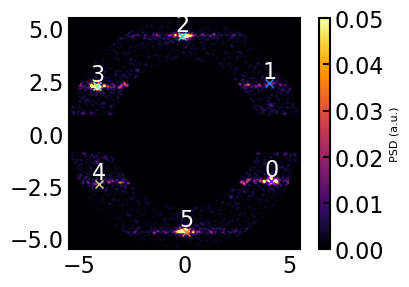

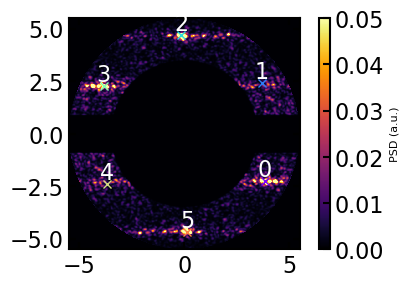

In [44]:
# CHANGE THESE VALUES AT THE TOP   
NUM_SCANS = 2
data_channels = ['TR Phase']         
line_dir = 'Trace'
padding = 2
inner_rad_crop = 3.5 # radius for inner circle masking (est. min peak values)
outer_rad_crop = 5.5 # radius for outer circle masking (est. max peak values)
inner_w_crop = 2 # width for masking bar along fast-scan axis
vmax = 0.05 # max value for plotting PSD, between 0 and 1

# minimum prominences for each scan for peak finding
min_prom = [0.05, 0.08]
# minimum distances between peaks for each scan for peak finding
min_dist = [50, 50]

avg_ac_vecs = np.zeros((6,2))
for s, scan in enumerate(scans[0:NUM_SCANS]):
    for channel in data_channels:
        # pull out the data
        input_data = scan.channels[f'{channel}: {line_dir}'].data

        # make the FFT (actually a PSD)
        fft, kx, ky = make_FFT(input_data, window_size=scan.channels[f'{channel}: {line_dir}'].scan_size, 
                            r=inner_rad_crop, w=inner_w_crop, orientation='horz', padding=padding) 
        fft = scipy.ndimage.gaussian_filter(fft, 2)

        # one method for pulling peaks, works now
        fft, kx, ky = crop_circle(fft, kx, ky, c=(0,0), r=outer_rad_crop, invert=True)
        peaks = alternate_peak_finding(psd=fft, kx=kx, ky=ky, min_prom=min_prom[s], min_dist=int(min_dist[s]))
        print(f'Found {len(peaks)} peaks for scan {s}.')

        # plot FFT
        fig, ax1 = plt.subplots(1)
        display_plot = ax1.pcolormesh(kx, ky, fft, cmap = 'inferno', vmax=vmax)
        plt.colorbar(display_plot, ax = ax1, fraction = 0.045).set_label(f'PSD (a.u.)' , fontsize = 8 )
        ax1.set_aspect('equal')
        ax1.set_xlim([-outer_rad_crop, outer_rad_crop])
        ax1.set_ylim([-outer_rad_crop, outer_rad_crop])

        # Account for a weak third peak by summing up the other two 
        # used if the third peak is weak and very difficult to detect, may not need
        if len(peaks) < 6:
            peak5 = np.array([[peaks[0][0] + peaks[3][0], peaks[0][1] + peaks[3][1]]])
            peak6 = np.array([[peaks[1][0] + peaks[2][0], peaks[1][1] + peaks[2][1]]])
            peaks = np.vstack((peaks, peak5))
            peaks = np.vstack((peaks, peak6))

        # # plot the found peaks before you have everything optimized
        # cmap = plt.colormaps['rainbow']
        # for i, v in enumerate(peaks):
        #     norm_ind = i / len(peaks)
        #     ax1.plot(v[0], v[1], 'x', color=cmap(norm_ind), alpha=1)
        #     ax1.annotate(f'{i}', xy=(v[0], v[1]), color='w', ha='center', va='bottom')

        # sort the peaks in the order in a counterclockwise direction
        sort_peaks = np.zeros((6,2))
        pk_order = find_peak_order(peaks)
        cmap = plt.colormaps['rainbow']
        for p in range(6):
            pi = pk_order[p]
            sort_peaks[p][0] = peaks[pi][0]
            sort_peaks[p][1] = peaks[pi][1]
            ax1.plot(peaks[pi][0], peaks[pi][1], 'x', color=cmap(p/6), alpha=1)
            ax1.annotate(f'{p}', xy=(peaks[pi][0], peaks[pi][1]), color='w', ha='center', va='bottom')

        # set yourself up for averaging the vectors to correct drift
        for i, v in enumerate(peaks):
            avg_ac_vecs[i][0] += v[0]
            avg_ac_vecs[i][1] += v[1]

# actually average the vecs
avg_ac_vecs = avg_ac_vecs / NUM_SCANS



## Finding lattice vector lengths

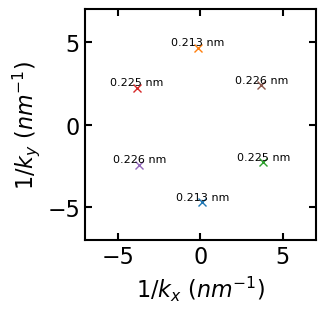

In [43]:
# FOR FINDING THE LATTICE VECTORS

lim = 7

fig, ax = plt.subplots()
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_aspect('equal')
lat_param = []

for i, v in enumerate(peaks):
    ax.plot(v[0], v[1], 'x')
    ang = round(vec_to_angle(v[0], v[1])*180/np.pi, 2)
    dist = np.sqrt(v[0]**2 + v[1]**2) # getting the length of this vector
    lat_param.append(1/dist)
    ax.annotate(f'{1/dist:.3f} nm', xy=(v[0], v[1]), color='k', fontsize=8, ha='center', va='bottom')
    ax.set_xlabel(r'1/$k_{x}$ ($nm^{-1}$)')
    ax.set_ylabel(r'1/$k_{y}$ ($nm^{-1}$)')





## Finding graphene orientation

[33.17, 91.64, 149.39, 213.17, 271.64, 329.39]
[62.4, 120.51, 181.28, 242.4, 300.52]


Text(0.5, 1.0, 'AC: [33.17, 91.64, 149.39, 213.17, 271.64, 329.39]° \n ZZ: [62.4, 120.51, 181.28, 242.4, 300.52]°')

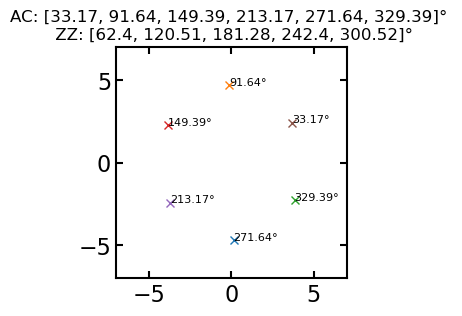

In [ ]:
# FOR FINDING THE ARMCHAIR AND ZIGZAG ORIENTATIONS

lim = 7

fig, ax = plt.subplots()
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_aspect('equal')
ac_ang = []
zz_ang = []

for i, v in enumerate(peaks):
    ax.plot(v[0], v[1], 'x')
    ang = round(vec_to_angle(v[0], v[1])*180/np.pi, 2)
    ac_ang.append(ang)
    ax.annotate(f'{ang}°', xy=(v[0], v[1]), color='k', fontsize=8, ha='center', va='bottom')


ac_ang = sorted(ac_ang)
for i in range(len(ac_ang) - 1):
    zz_ang.append(round((ac_ang[i] + ac_ang[i+1])/2, 2))
    
print(ac_ang)
print(zz_ang)

ax.set_title(f'AC: {ac_ang}° \n ZZ: {zz_ang}°', fontsize=12)



# Fitting a moire

## Fitting code for moire

In [ ]:
def make_FFT(input_data, padding=2, window_size=(1,1), r=None, wh=None, wv=None):
    sy, sx = input_data.shape
    hanning_window = np.sqrt(np.outer(scipy.signal.windows.hann(sy), scipy.signal.windows.hann(sx))) 
    windowed_data = np.pad(np.multiply(input_data, hanning_window), [(sy * padding, sy * padding), (sx * padding, sx * padding)])
    nonwindowed_data = np.pad(input_data, [(sy * padding, sy * padding), (sx * padding, sx * padding)])
    window_fft = np.abs(scipy.fft.fftshift(scipy.fft.fft2(windowed_data)))
    fft = np.abs(scipy.fft.fftshift(scipy.fft.fft2(nonwindowed_data)))
    lx, ly = window_size
    scalex = lx * len(nonwindowed_data.T) / sx # nm
    scaley = ly * len(nonwindowed_data) / sy # nm
    xs = np.linspace(-len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T) / 2 / scalex, len(nonwindowed_data.T), endpoint = False)
    ys = np.linspace(-len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data) / 2 / scaley, len(nonwindowed_data), endpoint = False)

    if not r == None:
        window_fft = crop_circle(fft=window_fft, x=xs, y=ys, r=r)
    if not wh == None:
        window_fft = crop_line(fft=window_fft, x=xs, y=ys, w=wh, orientation='horizontal')
    if not wv == None:
        window_fft = crop_line(fft=window_fft, x=xs, y=ys, w=wv, orientation='vert')

    PSD = window_fft**2
    PSD = PSD/np.amax(PSD)

    return PSD, xs, ys


def alternate_peak_finding(psd, kx, ky, min_prom=0.1, min_dist=10):
    peaks = skimage.feature.peak_local_max(psd, threshold_abs = min_prom, min_distance = min_dist)
    ac_vecs = np.array([])
    counter = 0
    for peak in peaks:
        temp_vec = np.array([[kx[peak[1]],
                            ky[peak[0]]]])
        if counter == 0:
            ac_vecs = temp_vec
            counter +=1
        else:
            ac_vecs = np.vstack((ac_vecs, temp_vec))
    return ac_vecs


# create unit vector from any (x, y). Assumes origin at (0, 0).
def unit_vec(x, y):
    arr = np.array([x, y])
    return arr / np.linalg.norm(arr)


# returns the angle of a vector with origin at (0, 0) 
def vec_to_angle(x, y): 
    v1_u = unit_vec(x, y)
    if (y < 0):
        v2_u = np.array([-1, 0]) # unit vec along negative x-axis
        ang = np.arccos(np.dot(v1_u, v2_u)) + np.pi
    else:
        v2_u = np.array([1, 0]) # unit vec along x-axis
        ang = np.arccos(np.dot(v1_u, v2_u))
    return ang


def crop_circle(fft, x, y, c=(0,0), r=0.1, invert=False):
    """
    Takes an FFT/diffraction pattern and returns the image outside of a circle around the center.
    Can also return the FFT cropped to a circle around a certain region if invert = True (default is False).

    r = radius
    c = (x, y) = center of circle, tuple of floats
    x, y = coordinates of the image relative to the indices of the image
    """
    # extract center coordinates
    x0, y0 = c

    # find indices where there are points within the bound box on both ends
    x_ind_max = np.where(x < (x0 + r))
    x_ind_min = np.where(x > (x0 - r))
    y_ind_max = np.where(y < (y0 + r))
    y_ind_min = np.where(y > (y0 - r))

    # find the points that fulfill both conditions
    x_ind = np.intersect1d(x_ind_min, x_ind_max)
    y_ind = np.intersect1d(y_ind_min, y_ind_max)

    # initialize a mask of zeros
    mask = np.ones(fft.shape)

    # only write values that are within the circle
    for yi in y_ind:
        for xi in x_ind:
            # make sure they're within a circle
            radius = np.sqrt((y[yi] - y0)**2 + (x[xi] - x0)**2)
            if radius <= r:
                mask[yi, xi] = 0
            else:
                pass

    if invert == False:
        return mask * fft
    else:
        xs = x[np.amin(x_ind):np.amax(x_ind)]
        ys = y[np.amin(y_ind):np.amax(y_ind)]
        full_fft = (1-mask) * fft
        crop_fft = full_fft[np.amin(y_ind):np.amax(y_ind), np.amin(x_ind):np.amax(x_ind)]
        return crop_fft, xs, ys


def crop_line(fft, x, y, w=1, orientation='vert'):
    """
    Takes an FFT and removes the artifact line from the fast scan direction.
    x, y = coordinates of the image relative to the indices of the image
    w = width of the line
    """
    x_ind_max = np.where(y < (w/2))
    x_ind_min = np.where(y > -(w/2))
    x_ind = np.intersect1d(x_ind_min, x_ind_max)

    x_max = np.amax(x_ind)
    x_min = np.amin(x_ind)

    mask = np.ones(fft.shape)
    if orientation == 'vert':
        mask[:, x_min:x_max] = 0
    else:
        mask[x_min:x_max, :] = 0

    return mask * fft


def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    """
    Fits a 2D Gaussian. 
    """

    x, y = xy
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


def gaussian_peak_fitting(fft, kx, ky, peak_est, crop_rad=[0.05], gaus_est=[1, 0.003, 0.003, 0]):
    """
    fft = np.array of M x N floats
    kx = np.array of N x 1 floats corresponding to the scaling of the fft
    ky = np.array of M x 1 floats corresponding to the scaling of the fft
    peak_est = np.array of 6 x 2 floats corresponding to each peak and its x,y 
    crop_rad = either a 1 or 6 floats in a list, cropping radius around each estimated peak for fitting
    gaus_est = fitting parameters for the gaussian

    Crops each fft around the estimated peak, fits a 2D Gaussian around it, then 
    returns that peak position in the form of a 6 x 2 np.array of floats
    """
    # lengthen the cropping radius if it's only one float
    if len(crop_rad) == 1:
        crop_rad = np.ones((6)) * crop_rad[0]

    # fit_data = np.zeros((6, len(fft.ravel())))
    fit_peaks = np.zeros((6,2))

    # loop through all the peaks
    for p in range(len(peak_est)):
        # only show a small circle around the peak
        # center of the peak is chosen manually
        px, py = peak_est[p]
        fft_cropped, crop_kx, crop_ky = crop_circle(fft=fft, x=kx, y=ky, c=(px,py), r=crop_rad[p], invert=True)
        psd_cropped = fft_cropped / np.amax(fft_cropped)

        # create the xy data for fitting the 2D Gaussian
        x, y = np.meshgrid(crop_kx, crop_ky)

        # set up initial guess for curvefitting for a single peak
        # guess = xy, amplitude, x0, y0, sigma_x, sigma_y, theta
        # good initial guesses: (1, peak x, peak y, 0.003, 0.003, 0)
        initial_guess = (gaus_est[0], px, py, gaus_est[1], gaus_est[2], gaus_est[3])

        # set up the bounds
        bounds_min = [-np.inf, px-crop_rad[p], py-crop_rad[p], 0., 0., -np.pi]
        bounds_max = [np.inf, px+crop_rad[p], py+crop_rad[p], np.inf, np.inf, np.pi]

        # do curve fit
        popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), psd_cropped.ravel(), p0=initial_guess, bounds=(bounds_min, bounds_max), maxfev=6000)

        fit_peaks[p, 0] = popt[1]
        fit_peaks[p, 1] = popt[2]

        # determine the error
        fit = twoD_Gaussian((x, y), *popt)
        rss = np.sum((psd_cropped.ravel() - fit)**2)

    return fit_peaks, rss


def find_sorted_ind(val, lst, rev=False):
    sort_lst = sorted(lst, reverse=rev)
    return int(sort_lst.index(val))


def find_peak_order(peaks):
    """ 
    Find the angle of each of the peaks. Determine the indices of the peaks closest to 
    -30, 30, 90, 150, 210, and 270 deg relative to the positive x axis. Returns
    those indices in that order.
    """
    # calculate the angle of each peak
    ang = []
    sort_ang = []
    sort_order = []
    for i, v in enumerate(peaks):
        temp_ang = round(vec_to_angle(v[0], v[1])*180/np.pi, 2)
        ang.append(temp_ang)

    pk_order = np.zeros(6)
    diff = [abs(i - 330) for i in ang] # find first angle, which is closest to 330 deg
    # find minimum where this is the angle that matches most closely
    zeroth_ind = np.where(min(diff) == diff)[0][0]

    # find the number of positive and negative values in this list
    diff2 = [i - ang[zeroth_ind] for i in ang]
    pos = 0
    neg = 0
    for n in diff2:
        if n > 0:
            pos += 1
        elif n < 0:
            neg += 1
        else:
            pass
            
    # sort everything now
    pk_order[0] = zeroth_ind
    for i, v in enumerate(diff2):
        # if a value is positive, put it after the initial value
        # realistically there is only going to be one positive value
        if v > 0:
            ind = find_sorted_ind(v, diff2, rev=True)
            ind += pos
        elif v == 0:
            ind = 0
        else:
            ind = find_sorted_ind(v, diff2, rev=False)
            ind += (pos + 1)
        pk_order[ind] = i



    return np.asarray(pk_order, dtype=int)

def compute_gBN(gg1, gg2, gg3, guess=(10 * np.pi / 180, 2.0 * np.pi / 180, 0.04, 80 * np.pi / 180), plot = False):

    # G1 = 2 * np.pi / aa * np.array([[1], [-1/np.sqrt(3)]])
    # G2 = 2 * np.pi / aa * np.array([[0], [2/np.sqrt(3)]])

    # BN1 = 2 * np.pi / ab * np.array([[1], [-1/np.sqrt(3)]])
    # BN2 = 2 * np.pi / ab * np.array([[0], [2/np.sqrt(3)]])


    aa = 0.246
    ab = 0.2504
    #print(aa**2)
    delta = aa*(1/aa - 1/ab)
    G1 = aa * np.array([[1], [0]]) 
    G2 = aa * np.array([[-1/2], [np.sqrt(3)/2]])

    BN1 = ab * np.array([[1], [0]]) 
    BN2 = ab * np.array([[-1/2], [np.sqrt(3)/2]])

    def R(theta):
        return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    def S(eps, phi):
        return np.array([[1, 0], [0, 1]]) + (eps * R(phi).T @ np.array([[1, 0], [0, -0.16]]) @ R(phi))

    def transformed_moire_vecs(t, theta, eps, phi):
        #transforming with twist and strain in real space
        G1_tr = R(t) @ R(theta) @ S(eps, phi) @ G1
        G2_tr = R(t) @ R(theta) @ S(eps, phi) @ G2
        BN1_tr = R(t) @ BN1
        BN2_tr = R(t) @ BN2

        #converting transformed vectors to reciprocal space
        #note that these are now 60° apart
        A = 2*np.pi/(G1_tr[0]*G2_tr[1] - G1_tr[1]*G2_tr[0])
        G1_rec = A * np.array([G2_tr[1], -G2_tr[0]])
        G2_rec = A * np.array([-G1_tr[1], G1_tr[0]])

        A_bn = 2*np.pi/(BN1_tr[0]*BN2_tr[1] - BN1_tr[1]*BN2_tr[0])
        BN1_rec = A_bn * np.array([BN2_tr[1], -BN2_tr[0]])
        BN2_rec = A_bn * np.array([-BN1_tr[1], BN1_tr[0]])

        #moire vectors in reciprocal space = difference of G and BN RLVs
        G_M1 = G1_rec - BN1_rec
        G_M2 = G2_rec - BN2_rec
        G_M3 = G_M2 - G_M1
        #third moire vector is difference of first 2 because they are 60° apart -- this combination gives (1,2,3) clockwise
        return [G_M1, G_M2, G_M3]

    #for trial moire parameters, returns difference of actual vectors and vectors calculated for trial parameters
    def res(moire_params):
        test_vecs = transformed_moire_vecs(moire_params[0], moire_params[1], moire_params[2], moire_params[3])
        res = np.array(test_vecs) - np.array([gg1, gg2, gg3])
        return res.flatten()
    

    # bounds for global rotation angle, twist angle, strain, and strain angle
    low_bound = [0, 0, 0, 0]
    upper_bound =[np.pi, np.pi/3, 1, np.pi]
    result = scipy.optimize.least_squares(res, guess, bounds = (low_bound, upper_bound), method='trf', gtol=1E-15, max_nfev=6000)
    if not result.success:
        raise Exception(result)
    

    if not result.success:
        raise Exception(result)
    
    # find the residual sum of squares
    rss = np.sum(res(result.x)**2)


    if plot:
        plt.figure(figsize=(3,3))
        for gg in [gg1, gg2, gg3]:
            plt.plot(gg[0][0], gg[1][0], 'ko', markersize=12)
            plt.plot(-gg[0][0], -gg[1][0], 'ko', markersize=12)

        fit_vecs = transformed_moire_vecs(*result.x)
        for gg in fit_vecs:
            plt.plot(gg[0][0], gg[1][0], 'x', markersize=12, color='grey')
            plt.plot(-gg[0][0], -gg[1][0], 'x',  markersize=12, color='grey')


        ax = plt.gca()
        plt.ylabel(r'$k_Y$ ($\mathrm{nm^{-1}}$)', size = 14)
        plt.xlabel(r'$k_X$ ($\mathrm{nm^{-1}}$)', size = 14)
        ax.set_aspect('equal')
        # ax.set_xlim(-1.5, 1.5)
        # ax.set_ylim(-1.5, 1.5)
        # ax.set_facecolor('dimgrey')
        ax.patch.set_alpha(1)
        fig.patch.set_alpha(0.0)
        ax.tick_params(labelsize=14)
        # ax.set_xticks(np.arange(-1, 1, 0.5), fontsize=14)
        # ax.set_yticks(np.arange(-1, 1, 0.5), fontsize=14)
   
        plt.tight_layout()
        plt.savefig(f'{data_root}/fit_psd.png', format='png', dpi=300, bbox_inches='tight', transparent=True)
    return result.x, rss


def compute(gg1, gg2, gg3, guess=(100 * np.pi / 180, 1.7 * np.pi / 180, 0.05, 80 * np.pi / 180), plot = False):
    # either fits
    aa = 0.246

    G1 = 2 * np.pi / aa * np.array([[1], [-1/np.sqrt(3)]])
    G2 = 2 * np.pi / aa * np.array([[0], [2/np.sqrt(3)]])

    # G1 = 4 * np.pi / (np.sqrt(3) * aa) * np.array([[0], [-1]])
    # G2 = 4 * np.pi / (np.sqrt(3) * aa) * np.array([[np.sqrt(3) / 2], [1 / 2]])

    # G1 = 2 * np.pi / aa * np.array([[0], [2/np.sqrt(3)]])
    # G2 = 2 * np.pi / aa * np.array([[1], [1/np.sqrt(3)]])

    def T(theta):
        return np.array([[0,-theta], [theta,0]])
    def R(theta):
        return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    def S(eps, phi):
        return eps * np.linalg.inv(R(phi)) @ np.array([[1, 0], [0, -0.16]]) @ R(phi)
    def g1(t, theta, eps, phi):
        return R(t) @  (T(theta) + S(eps, phi)).T @ G1
    def g2(t, theta, eps, phi):
        return R(t) @ (T(theta) + S(eps, phi)).T @ G2
    def g3(t, theta, eps, phi):
        return g1(t, theta, eps, phi) + g2(t, theta, eps, phi)
    def res(x):
        G_M1 = g1(x[0], x[1], x[2], x[3]) - gg1
        G_M2 = g2(x[0], x[1], x[2], x[3]) - gg2
        G_M3 = g3(x[0], x[1], x[2], x[3]) - gg3
        return np.array([G_M1[0][0], G_M1[1][0], G_M2[0][0], G_M2[1][0], G_M3[0][0], G_M3[1][0]])
    

    # bounds for global rotation angle, twist angle, strain, and strain angle
    low_bound = [0, 0, 0, 0]
    upper_bound =[np.pi, np.pi/3, 1, np.pi]
    result = scipy.optimize.least_squares(res, guess, bounds = (low_bound, upper_bound), max_nfev=6000)
    if not result.success:
        raise Exception(result)
    
    # find the residual sum of squares
    rss = np.sum(res(result.x)**2)
        
    if plot:
        plt.figure(figsize=(3,3))
        for gg in [gg1, gg2, gg3]:
            plt.plot(gg[0][0], gg[1][0], 'ko', markersize=12)
            plt.plot(-gg[0][0], -gg[1][0], 'ko', markersize=12)
        for gg in [g1, g2, g3]:
            plt.plot([gg(*result.x)[0]], [gg(*result.x)[1]], 'x', color='grey')
            plt.plot([-gg(*result.x)[0]], [-gg(*result.x)[1]], 'x', color='grey')

        ax = plt.gca()
        plt.ylabel(r'$k_Y$ ($\mathrm{nm^{-1}}$)', size = 14)
        plt.xlabel(r'$k_X$ ($\mathrm{nm^{-1}}$)', size = 14)
        ax.set_aspect('equal')
        # ax.set_xlim(-1.5, 1.5)
        # ax.set_ylim(-1.5, 1.5)
        # ax.set_facecolor('dimgrey')
        ax.patch.set_alpha(1)
        fig.patch.set_alpha(0.0)
        ax.tick_params(labelsize=14)
        # ax.set_xticks(np.arange(-1, 1, 0.5), fontsize=14)
        # ax.set_yticks(np.arange(-1, 1, 0.5), fontsize=14)
   
        plt.tight_layout()
        plt.savefig(f'{data_root}/fit_psd.png', format='png', dpi=300, bbox_inches='tight', transparent=True)
    return result.x, rss


def run_moire_fit(peaks, param_guess = None, ggs=[], plot=False, gBN=False):

    """ 
    peaks = a np.array of size (N, 2) corresponding to N number of peaks
    param_guess = guess for parameters (global angle, twist, strain, strain angle) 
    all angles are in radians, and strain is in absolute (not percentage)

    returns the global angle, twist, strain, and strain angle (in radians and absolute values)
    """
    # pks in order: 330, 30, 90, 150, 180, 210, 270
    pk0, pk1, pk2, pk3, pk4, pk5 = find_peak_order(peaks)

     # pk1 = -30 deg or 330 deg, pk2 = 90 deg, pk3 = 30 deg
    if not ggs:
        if gBN:
            gg1 = 2 * np.pi * np.array([[peaks[pk2][0]], [peaks[pk2][1]]])
            gg2 = 2 * np.pi * np.array([[peaks[pk3][0]], [peaks[pk3][1]]])
            gg3 = 2 * np.pi * np.array([[peaks[pk4][0]], [peaks[pk4][1]]])
        else:
            gg1 = 2 * np.pi * np.array([[peaks[pk5][0]], [peaks[pk5][1]]])
            gg2 = 2 * np.pi * np.array([[peaks[pk1][0]], [peaks[pk1][1]]])
            gg3 = 2 * np.pi * np.array([[peaks[pk0][0]], [peaks[pk0][1]]])
    else:
        gg1 = ggs[0]
        gg2 = ggs[1]
        gg3 = ggs[2]

    if param_guess is None:
        param_guess = (20 * np.pi / 180, 1.1 * np.pi / 180, 0.07, 20 * np.pi / 180)

    if gBN:
        result, rss = compute_gBN(gg1, gg2, gg3, plot=plot)
    else:
        result, rss = compute(gg1, gg2, gg3, plot=plot)
    return result, rss, gg1, gg2, gg3



## Run this once to get an idea of where the peaks are

Scan size is (460.51985873542833, 452.02308831256414) nm.
4
Scan size is (463.2707695592793, 450.14422790953995) nm.
4
ψ: 8.835°, θ: 0.389° (λ = 36.26 nm), ε: 0.035%, ϕ: 43.235°


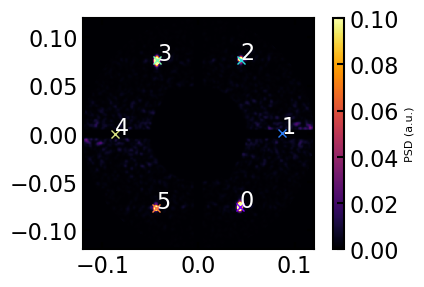

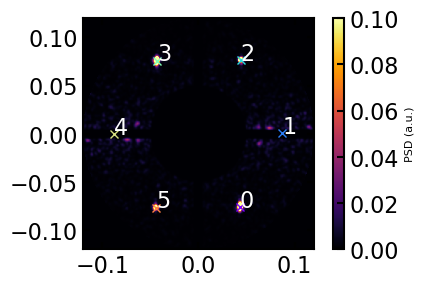

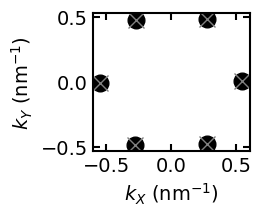

In [ ]:
# CHANGE THESE VALUES AT THE TOP             
line_dir = 'Trace'
padding = 2
data_channels = ['TR Phase']
NUM_SCANS = 2 # change every time
inner_rad_crop = 0.05
horz_w_crop = 0.01
vert_w_crop = 0.01
outer_rad_crop = 0.12


min_prom = [0.1, 0.1, 0.1, 0.075]
min_dist = [10, 10, 20, 20]

# drift, drift_err = estimate_drift_from_cc(scans=scans, channel_name=f'{data_channels[0]}: {line_dir}')
# print(drift, drift_err)

avg_ac_vecs = np.zeros((6,2))
diff_odd = np.zeros((int(NUM_SCANS/2 - 1), 6, 2))
diff_even = np.zeros((int(NUM_SCANS/2 - 1), 6, 2))
diff = np.zeros((NUM_SCANS-1, 6, 2))
for s, scan in enumerate(scans[0:NUM_SCANS]):
    for channel in data_channels:
        # pull out the data
        input_data = scan.channels[f'{channel}: {line_dir}'].data
        # input_data = np.rot90(input_data, k=3) # rotate data 90 deg CW essentially
        scan_size = scan.channels[f'{channel}: {line_dir}'].scan_size
        print(f'Scan size is {scan_size} nm.')

        # make the FFT (actually a PSD)
        fft, kx, ky = make_FFT(input_data, window_size=scan.channels[f'{channel}: {line_dir}'].scan_size, 
                            r=inner_rad_crop, wh=horz_w_crop, wv=vert_w_crop, padding=padding) 
        fft = scipy.ndimage.gaussian_filter(fft, 2)

        # one method for pulling peaks, works now
        fft, kx, ky = crop_circle(fft, kx, ky, c=(0,0), r=outer_rad_crop, invert=True)
        peaks = alternate_peak_finding(psd=fft, kx=kx, ky=ky, min_prom=min_prom[s], min_dist=int(min_dist[s]))
        print(len(peaks))

        # plot FFT
        fig, ax1 = plt.subplots()
        ax1.set_aspect('equal')
        display_plot = ax1.pcolormesh(kx, ky, fft, cmap = 'inferno', vmin=0.00, vmax=0.1)
        plt.colorbar(display_plot, ax = ax1, fraction = 0.045).set_label(f'PSD (a.u.)', fontsize = 8)
        ax1.set_xlim([-outer_rad_crop, outer_rad_crop])
        ax1.set_ylim([-outer_rad_crop, outer_rad_crop])

        if len(peaks) < 6:
            # CHANGE THESE INDICES EVERY TIME RISA
            peak5 = np.array([[peaks[0][0] + peaks[3][0], peaks[0][1] + peaks[3][1]]])
            peak6 = np.array([[peaks[1][0] + peaks[2][0], peaks[1][1] + peaks[2][1]]])
            peaks = np.vstack((peaks, peak5))
            peaks = np.vstack((peaks, peak6))

        # peaks, rss = gaussian_peak_fitting(fft=fft, kx=kx, ky=ky, peak_est=peaks, crop_rad=[0.025])

        # # plot the found peaks
        # for i, v in enumerate(peaks):
        #     cmap = plt.colormaps['rainbow']
        #     norm_ind = i / len(peaks)
        #     ax1.plot(v[0], v[1], 'x', color=cmap(norm_ind), alpha=1)
        #     ax1.annotate(f'{i}', xy=(v[0], v[1]), color='w', size=16)

        # sort the peaks in the order in a counterclockwise direction
        sort_peaks = np.zeros((6,2))
        pk_order = find_peak_order(peaks)
        for p in range(6):
            pi = pk_order[p]
            sort_peaks[p][0] = peaks[pi][0]
            sort_peaks[p][1] = peaks[pi][1]
            ax1.plot(peaks[pi][0], peaks[pi][1], 'x', color=cmap(p/6), alpha=1)
            ax1.annotate(f'{p}', xy=(peaks[pi][0], peaks[pi][1]), color='w', ha='center', va='bottom')

        # set yourself up for averaging the vectors to correct drift
        for p, val in enumerate(sort_peaks):
            avg_ac_vecs[p][0] += val[0]
            avg_ac_vecs[p][1] += val[1]

# actually average the vecs
peaks = avg_ac_vecs / NUM_SCANS

fit_params, rss, gg1, gg2, gg3 = run_moire_fit(peaks=peaks, plot=True, gBN=True)
params =f'ψ: {fit_params[0] * 180 / np.pi:.3f}°' \
        + f', θ: {fit_params[1] * 180 / np.pi:.3f}° (λ = {np.round(moire_wavelength(fit_params[1] * 180 / np.pi),2)} nm)' \
        + f', ε: {fit_params[2] * 100:.3f}%' + f', ϕ: {fit_params[3] * 180 / np.pi:.3f}°'
print(params)
# store these for the next round to raster across the image
guess = fit_params
guess_peaks = peaks



0.04308309279069056 -0.07603897833594114
0.08703219035523002 0.0008867573181084443
0.04394909756453946 0.07692573565404959
-0.043083092790690614 0.07603897833594114
-0.08703219035523008 -0.0008867573181084165
-0.04394909756453946 -0.07692573565404956


(-0.2, 0.2)

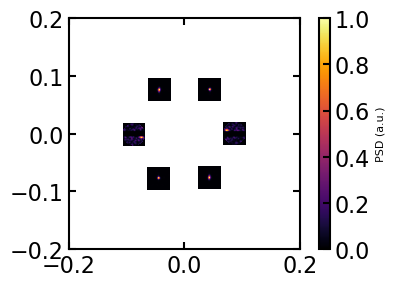

In [ ]:
# test out the crop radius
fig, ax = plt.subplots()
for p in range(6):
    # only show a small circle around the peak
    # center of the peak is chosen manually
    px, py = peaks[p]
    print(px, py)
    fft_cropped, crop_kx, crop_ky = crop_circle(fft=fft, x=kx, y=ky, c=(px,py), r=0.02, invert=True)
    psd_cropped = fft_cropped / np.amax(fft_cropped)
    ax.set_aspect('equal')
    display_plot = ax.pcolormesh(crop_kx, crop_ky, psd_cropped, cmap = 'inferno', vmin=0, vmax=1)
    
plt.colorbar(display_plot, ax = ax, fraction = 0.045).set_label(f'PSD (a.u.)' , fontsize=8)

ax.set_xlim(-outer_rad_crop, outer_rad_crop)
ax.set_ylim(-outer_rad_crop, outer_rad_crop)
    
    

## Drift correcting an entire image

Scan size is (978.5981609461242, 508.116443290357), and scan shape is (512, 512).
V_fast: 2455.19 nm/s, V_slow: 4.62 nm/s.
Scan time estimated at 212.13 s (3.54 min).
Scan size is (981.659801613554, 506.53704662749305), and scan shape is (512, 512).
V_fast: 2447.56 nm/s, V_slow: 4.63 nm/s.
Scan time estimated at 212.13 s (3.54 min).
Scan size is (978.116746086972, 507.6717715808836), and scan shape is (512, 512).
V_fast: 2453.04 nm/s, V_slow: 4.62 nm/s.
Scan time estimated at 212.13 s (3.54 min).


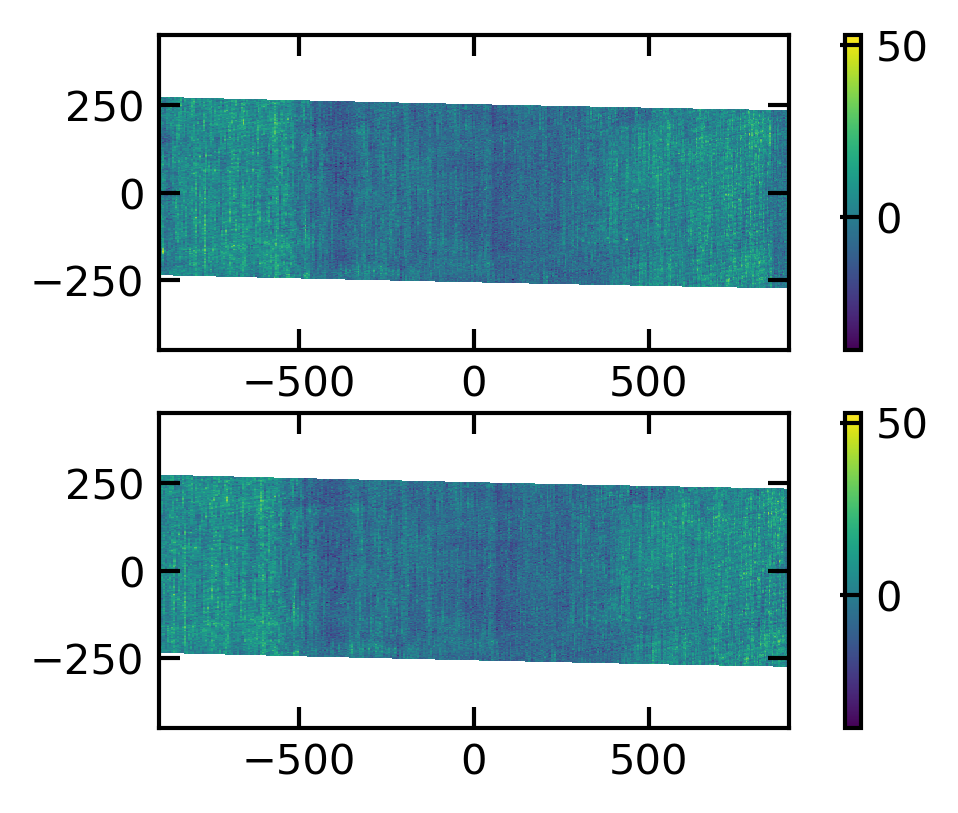

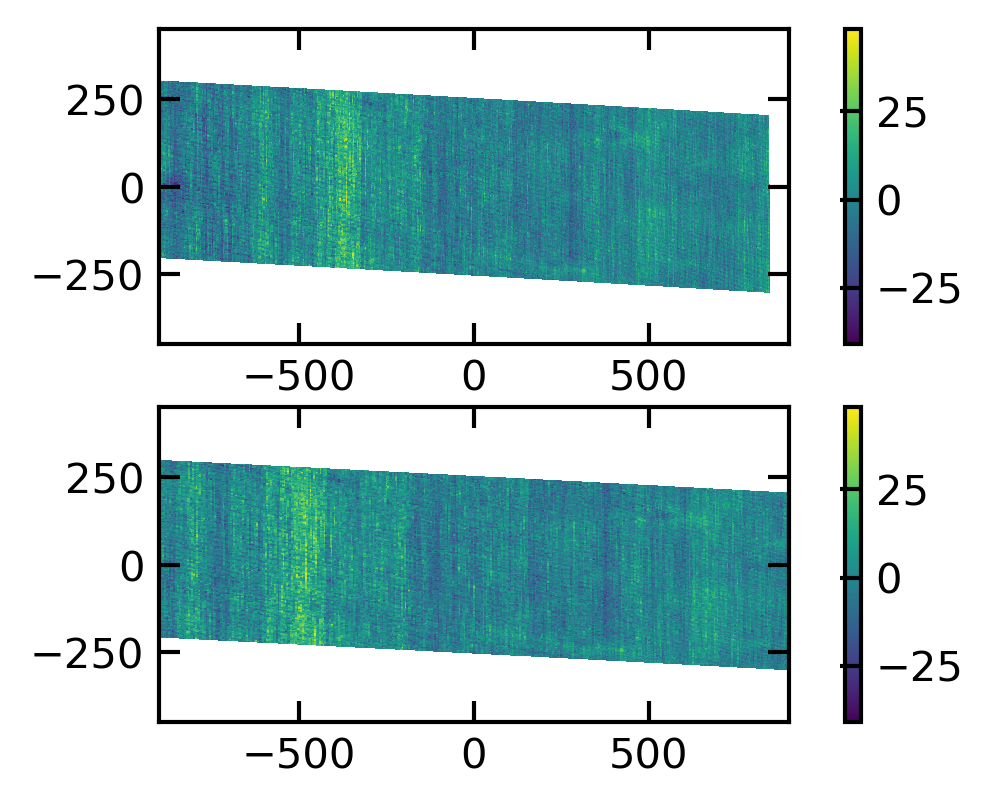

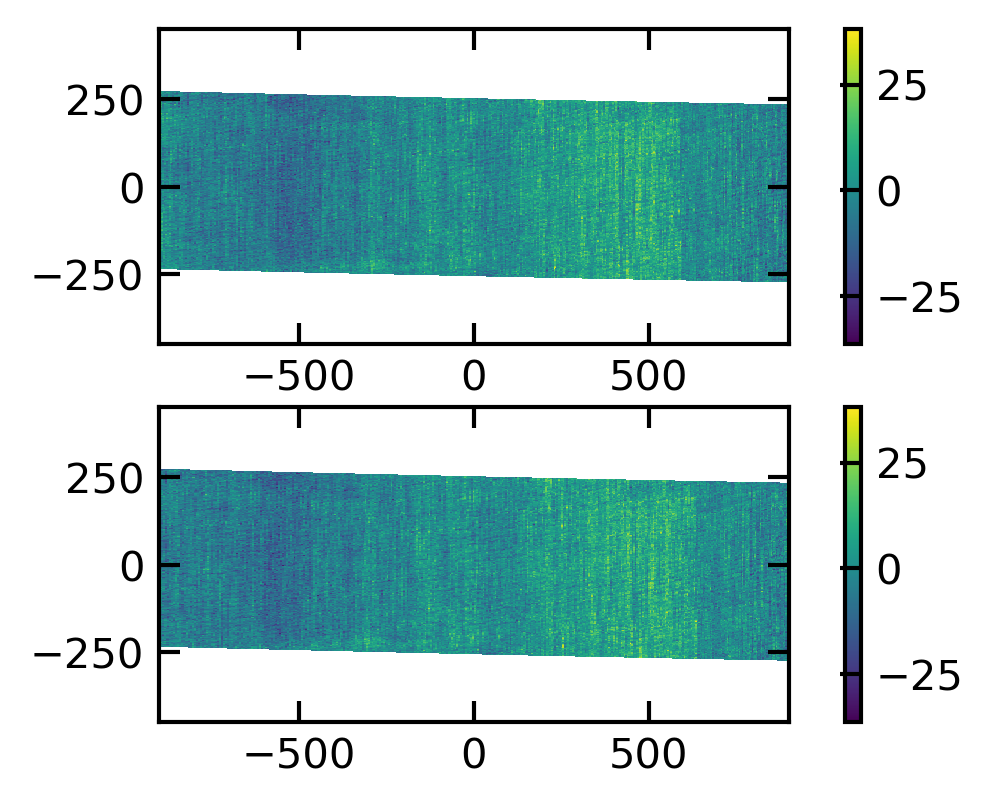

In [ ]:
def drift_correct_image(scan, channel, line_dir, drift, plot=False):

    """
    Assumes that the fast scan axis is y and that you are using trace.
    """

    # getting all the constants
    input_data = scan.channels[f'{channel}: {line_dir}'].data
    scan_shape = scan.channels[f'{channel}: {line_dir}'].data.shape # shape of data in pixels
    scan_size = scan.channels[f'{channel}: {line_dir}'].scan_size # in nm
    pixel_size = np.array([scan_size[1]/scan_shape[1], scan_size[0]/scan_shape[0]]) # in nm
    scan_rate = scan.scan_rate # in Hz
    scan_dir = scan.channels[f'{channel}: {line_dir}'].scan_direction
    x_sensor = scan.channels[f'Xsensor: {line_dir}'].data
    y_sensor = scan.channels[f'Ysensor: {line_dir}'].data
    print(f'Scan size is {scan_size}, and scan shape is {scan_shape}.')

    vfast = 2*scan_rate * scan_size[1] # fast scan axis velocity, nm/s
    vslow = scan_size[0] * scan_rate / scan_shape[0] # slow scan axis velocity, nm/s
    print(f'V_fast: {vfast:.2f} nm/s, V_slow: {vslow:.2f} nm/s.')

    dx, dy = drift # drift along x and y in nm/s
    b, h = scan_size # nm

    # getting the sensor data for x and y
    x_sens = x_sensor 
    y_sens = y_sensor 

    cx = np.zeros(x_sens.shape)
    cy = np.zeros(y_sens.shape)

    # estimate time at each point along fast (pix) and slow (line) dimensions
    pix = np.reshape(np.arange(1, scan_shape[1]+1, 1), (1, -1))
    lines = np.reshape(np.arange(1, scan_shape[0]+1, 1), (1, -1))
    pixgrid = numpy.matlib.repmat(pix.T, 1, scan_shape[1])
    linegrid = numpy.matlib.repmat(lines, scan_shape[0], 1)
    time_per_line = 1 / scan_rate # s 
    timegrid = (pixgrid / scan_shape[1] * 0.5 * time_per_line) + (linegrid * time_per_line) # trace
    # timegrid = (pixgrid / scan_shape[1] * 0.5 * time_per_line) + (linegrid * time_per_line) + (0.5 * time_per_line) # retrace
    print(f'Scan time estimated at {np.amax(timegrid):.2f} s ({np.amax(timegrid)/60:.2f} min).')

    # # deformation in x and y 
    # defx = timegrid * dx / b
    # defy = timegrid * dy / h
    # if scan_dir == 'Up':
    #     cx = x_sens + ((-defx / (1+ defy)) * y_sens)
    #     cy = (1 / (1 + defy)) * y_sens
    # else:
    #     cx = (-defx / (1 - defy)) + x_sens + ((defx / (1 + defy)) * y_sens)
    #     cy = (-defy / (1- defy)) + ((1 / (1 - defy)) * y_sens)

    # deformation in x and y 
    defx = timegrid * dx 
    defy = timegrid * dy 
    if scan_dir == 'Down':
        cx = (b / (defx + b)) * x_sens
        cy = y_sens - ((defy / (b + defx)) * x_sens)
    else:
        cx = (b / (b - defx)) * (x_sens - defx)
        cy = ((defy / (b - defx)) * (x_sens - b)) + y_sens


    xmin, xmax = np.amin(cx), np.amax(cx)
    ymin, ymax = np.amin(cy), np.amax(cy)
    scan.channels[f"Ysensor: {line_dir}"].data = cy
    scan.channels[f"Xsensor: {line_dir}"].data = cx
    scan.channels[f"Xsensor: {line_dir}"].scan_size = (xmax - xmin, ymax - ymin)
    scan.channels[f"Xsensor: {line_dir}"].scan_size = (xmax - xmin, ymax - ymin)

    fig, [ax, ax1] = plt.subplots(2, dpi=300, figsize=[3*1.618,3])
    pm = ax.pcolormesh(x_sensor - np.average(x_sensor), y_sens - np.average(y_sensor), input_data)
    plt.colorbar(pm, ax=ax)
    pm = ax1.pcolormesh(cx - np.average(cx), cy - np.average(cy), input_data)
    plt.colorbar(pm, ax=ax1)

    # ax.scatter(x_sensor - np.average(x_sensor), y_sensor - np.average(y_sensor))
    # ax1.scatter(cx - np.average(cx), cy - np.average(cy))

    for a in [ax, ax1]:
        a.set_aspect('equal')
        xlim = 900
        ylim = xlim/2
        a.set_xlim([-xlim, xlim])
        a.set_ylim([-ylim, ylim])
        # a.set_xlim([-25, 25])
        # a.set_ylim([-25, 25])

    return scan

# drift, drift_err = estimate_drift_from_cc(scans=scans, channel_name=f'{data_channels[0]}: {line_dir}')
drift = [ 0.32017275, -0.01170725]
scans2 = []
for scan in scans:
    scan = drift_correct_image(scan, channel='TR Phase', line_dir='Trace', drift=drift)
    scans2.append(scan)



# For rastering across an image

In [111]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    """
    Fits a 2D Gaussian. 
    """

    x, y = xy
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


def gaussian_peak_fitting(fft, kx, ky, peak_est, crop_rad=[0.05], gaus_est=[1, 0.01, 0.01, 0], lock_global_ang=True):
    """
    fft = np.array of M x N floats
    kx = np.array of N x 1 floats corresponding to the scaling of the fft
    ky = np.array of M x 1 floats corresponding to the scaling of the fft
    peak_est = np.array of 6 x 2 floats corresponding to each peak and its x,y 
    crop_rad = either a 1 or 6 floats in a list, cropping radius around each estimated peak for fitting
    gaus_est = 

    Crops each fft around the estimated peak, fits a 2D Gaussian around it, then 
    returns that peak position in the form of a 6 x 2 np.array of floats
    """
    # lengthen the cropping radius if it's only one float
    if len(crop_rad) == 1:
        crop_rad = np.ones((6)) * crop_rad[0]

    # fit_data = np.zeros((6, len(fft.ravel())))
    fit_peaks = np.zeros((6,2))

    # loop through all the peaks
    for p in range(len(peak_est)):
        # only show a small circle around the peak
        # center of the peak is chosen manually
        px, py = peak_est[p]
        fft_cropped, crop_kx, crop_ky = crop_circle(fft=fft, x=kx, y=ky, c=(px,py), r=crop_rad[p], invert=True)
        psd_cropped = fft_cropped / np.amax(fft_cropped)

        # create the xy data for fitting the 2D Gaussian
        x, y = np.meshgrid(crop_kx, crop_ky)

        # set up initial guess for curvefitting for a single peak
        # guess = xy, amplitude, x0, y0, sigma_x, sigma_y, theta
        # good initial guesses: (1, peak x, peak y, 0.003, 0.003, 0)
        initial_guess = (gaus_est[0], px, py, gaus_est[1], gaus_est[2], gaus_est[3])

        # set up the bounds
        bounds_min = [-np.inf, px-crop_rad[p], py-crop_rad[p], 0., 0., -np.pi]
        bounds_max = [np.inf, px+crop_rad[p], py+crop_rad[p], np.inf, np.inf, np.pi]

        # do curve fit
        popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), psd_cropped.ravel(), p0=initial_guess, bounds=(bounds_min, bounds_max), maxfev=6000)

        fit_peaks[p, 0] = popt[1]
        fit_peaks[p, 1] = popt[2]

        # determine the error
        fit = twoD_Gaussian((x, y), *popt)
        rss = np.sum((psd_cropped.ravel() - fit)**2)

    return fit_peaks, rss


def alt2_peak_fitting(fft, kx, ky, peak_est, crop_rad=[0.05], prom=0.1, lock_global_ang=True):
    """
    fft = np.array of M x N floats
    kx = np.array of N x 1 floats corresponding to the scaling of the fft
    ky = np.array of M x 1 floats corresponding to the scaling of the fft
    peak_est = np.array of 6 x 2 floats corresponding to each peak and its x,y 
    crop_rad = either a 1 or 6 floats in a list, cropping radius around each estimated peak for fitting
    prom = 1D array of prominences to try for peakfinding in decreasing order

    Crops each fft around the estimated peak, find the peak in that cropped region, then 
    returns that peak position in the form of a 6 x 2 np.array of floats
    """
    # lengthen the cropping radius if it's only one float
    if len(crop_rad) == 1:
        crop_rad = np.ones((6)) * crop_rad[0]

    # fit_data = np.zeros((6, len(fft.ravel())))
    fit_peaks = np.zeros((6,2))

    # loop through all the peaks
    counter = 0
    for p in range(len(peak_est)):
        # only show a small circle around the peak
        # center of the peak is chosen manually
        px, py = peak_est[p]
        fft_cropped, crop_kx, crop_ky = crop_circle(fft=fft, x=kx, y=ky, c=(px,py), r=crop_rad[p], invert=True)
        psd_cropped = fft_cropped / np.amax(fft_cropped)


        # fit using peak detector rather than a Gaussian
        peaks = skimage.feature.peak_local_max(psd_cropped, threshold_abs = prom)
        while len(peaks) != 1:
            if len(peaks) > 1: # getting too many peaks (prom too low)
                prom = prom*1.1
            else: # getting too few peaks (prom too high)
                prom = prom*0.9
            peaks = skimage.feature.peak_local_max(psd_cropped, threshold_abs = prom)

        # pk_vecs = np.array([])
        temp_vec = np.array([crop_kx[peaks[0][1]],
                              crop_ky[peaks[0][0]]])
        if counter == 0:
            pk_vecs = temp_vec
            counter +=1
        else:
            pk_vecs = np.vstack((pk_vecs, temp_vec))

    return pk_vecs


## Extracting wavevectors from the up/down scans

In [ ]:

plt.close()

# CHANGE THESE VALUES AT THE TOP             
padding = 2 
crad = [0.02]
sigma = 1
nx = 10
ny = 10
horz_w_crop = 0.01
vert_w_crop = 0.005

# for 20 x 20, padding = 3, crad = 0.02, sigma = 1
# for 10 x 10, padding = 2, crad = 0.03, sigma = 1
# for 5 x 5, padding = 2, crad = 0.03, sigma = 1
# for 4 x 4, padding = 2, crad = 0.03, sigma = 1

# scan information
scan = scans[1]
channel = 'TR Phase'
line_dir = 'Retrace'
input_data = scan.channels[f'{channel}: {line_dir}'].data
scan_shape = scan.channels[f'{channel}: {line_dir}'].data.shape # shape of data in pixels
scan_size = scan.channels[f'{channel}: {line_dir}'].scan_size # in nm
pixel_size = np.array([scan_size[1]/scan_shape[1], scan_size[0]/scan_shape[0]]) # in nm
print(f'Scan size is {scan_size}, and scan shape is {scan_shape}')

# make the grid
x = np.array(np.linspace(0, scan_shape[1], nx+1), dtype=int)
y = np.array(np.linspace(0, scan_shape[0], ny+1), dtype=int)
gridx, gridy = np.meshgrid(x, y, sparse=True)

# determine new window size that you're pulling from
deltax = (gridx[0][1] - gridx[0][0]) 
deltay = gridy[1][0] - gridx[0][0]
crop_window = (deltax * pixel_size[0], deltay * pixel_size[1])
print(f'({deltax}, {deltay}) pixel region is {crop_window} nm')

# extract the spatial map for plotting
deltax_nm = deltax * pixel_size[0]
deltay_nm = deltay * pixel_size[1]
x_nm = np.array(np.arange(1, nx+1, 1) * deltax_nm, dtype=int)
y_nm = np.array(np.arange(1, ny+1, 1) * deltay_nm, dtype=int)
x_nm, y_nm = np.meshgrid(x_nm, y_nm)

for s, scan in enumerate(scans[0:2]):
    # create a new moire dictionary
    centers = np.zeros((ny, nx))
    moire = {
        'gauss_rss' : centers.copy(),
        'rss': centers.copy(),
        'global_ang': centers.copy(),
        'twist': centers.copy(),
        'wavelength': centers.copy(),
        'strain': centers.copy(),
        'strain_ang': centers.copy(),
        'gg1': (centers.copy()).tolist(),
        'gg2': (centers.copy()).tolist(),
        'gg3': (centers.copy()).tolist(),
    }

    # go through all the spatial positions in y
    for i in range(len(gridy)-1):
        # go through all the spatial positions in x
        print(i)
        for j in range(len(gridx[0])-1):
            # print(i, j)
            # extract the region of the input data within the bounding box
            x_min, x_max = gridx[0][j], gridx[0][j+1]
            y_min, y_max = gridy[i][0], gridy[i+1][0]
            temp = input_data[y_min:y_max, x_min:x_max]
            
            # make the FFT (actually a PSD)
            fft, kx, ky = make_FFT(temp, window_size=crop_window, 
                                r=inner_rad_crop, wh=horz_w_crop, wv=vert_w_crop, padding=padding) 
            fft, kx, ky = crop_circle(fft, kx, ky, c=(0,0), r=outer_rad_crop, invert=True)

            # blur it a bit for better peak finding
            fft = scipy.ndimage.gaussian_filter(fft, sigma)

            peaks = alt2_peak_fitting(fft=fft, kx=kx, ky=ky, peak_est=guess_peaks, crop_rad=crad)
            

            # run the fitting program
            fit_params, rss, gg1, gg2, gg3 = run_moire_fit(peaks=peaks, param_guess=guess, plot=False)

            # save the values
            moire['gauss_rss'][i, j] = 1
            moire['rss'][i, j] = rss
            moire['global_ang'][i, j] = fit_params[0] * 180 / np.pi
            moire['twist'][i, j] = fit_params[1] * 180 / np.pi
            moire['wavelength'][i,j] = moire_wavelength(fit_params[1] * 180 / np.pi)
            moire['strain'][i, j] = fit_params[2] * 100
            moire['strain_ang'][i, j] = fit_params[3] * 180 / np.pi
            moire['gg1'][i][j] = gg1
            moire['gg2'][i][j] = gg2
            moire['gg3'][i][j] = gg3

            params =f'ψ: {fit_params[0] * 180 / np.pi:.3f}°' \
                    + f', θ: {fit_params[1] * 180 / np.pi:.3f}° (λ = {np.round(moire_wavelength(fit_params[1] * 180 / np.pi),2)} nm)' \
                    + f', ε: {fit_params[2] * 100:.3f}%' + f', ϕ: {fit_params[3] * 180 / np.pi:.3f}°'
            # print(params)

    if s == 0:
        moire_up = moire.copy()
        print('Done with up scan.')
    else:
        moire_down = moire.copy()
        print('Down with down scan.')



Scan size is (2000.0, 2000.0), and scan shape is (4096, 4096)
(409, 409) pixel region is (199.70703125, 199.70703125) nm
0
1
2
3
4
5
6
7
8
9
Done with up scan.
0
1
2
3
4
5
6
7
8
9
Down with down scan.


In [ ]:
### using Gaussian fitting
plt.close()

# CHANGE THESE VALUES AT THE TOP             
padding = 3 
crad = [0.02]
sigma = 2
nx = 40
ny = 40
horz_w_crop = 0.01
vert_w_crop = 0.01

# for 20 x 20, padding = 3, crad = 0.02, sigma = 1
# for 10 x 10, padding = 2, crad = 0.03, sigma = 1
# for 5 x 5, padding = 2, crad = 0.03, sigma = 1
# for 4 x 4, padding = 2, crad = 0.03, sigma = 1

# scan information
scan = scans[1]
channel = 'TR Phase'
line_dir = 'Retrace'
input_data = scan.channels[f'{channel}: {line_dir}'].data
scan_shape = scan.channels[f'{channel}: {line_dir}'].data.shape # shape of data in pixels
scan_size = scan.channels[f'{channel}: {line_dir}'].scan_size # in nm
pixel_size = np.array([scan_size[1]/scan_shape[1], scan_size[0]/scan_shape[0]]) # in nm
print(f'Scan size is {scan_size}, and scan shape is {scan_shape}')

# make the grid
x = np.array(np.linspace(0, scan_shape[1], nx+1), dtype=int)
y = np.array(np.linspace(0, scan_shape[0], ny+1), dtype=int)
gridx, gridy = np.meshgrid(x, y, sparse=True)

# determine new window size that you're pulling from
deltax = (gridx[0][1] - gridx[0][0]) 
deltay = gridy[1][0] - gridx[0][0]
crop_window = (deltax * pixel_size[0], deltay * pixel_size[1])
print(f'({deltax}, {deltay}) pixel region is {crop_window} nm')

# extract the spatial map for plotting
deltax_nm = deltax * pixel_size[0]
deltay_nm = deltay * pixel_size[1]
x_nm = np.array(np.arange(1, nx+1, 1) * deltax_nm, dtype=int)
y_nm = np.array(np.arange(1, ny+1, 1) * deltay_nm, dtype=int)
x_nm, y_nm = np.meshgrid(x_nm, y_nm)

for s, scan in enumerate(scans[0:2]):
    # create a new moire dictionary
    centers = np.zeros((ny, nx))
    moire = {
        'gauss_rss' : centers.copy(),
        'rss': centers.copy(),
        'global_ang': centers.copy(),
        'twist': centers.copy(),
        'wavelength': centers.copy(),
        'strain': centers.copy(),
        'strain_ang': centers.copy(),
        'gg1': (centers.copy()).tolist(),
        'gg2': (centers.copy()).tolist(),
        'gg3': (centers.copy()).tolist(),
    }

    # go through all the spatial positions in y
    for i in range(len(gridy)-1):
        # go through all the spatial positions in x
        print(i)
        for j in range(len(gridx[0])-1):
            # print(i, j)
            # extract the region of the input data within the bounding box
            x_min, x_max = gridx[0][j], gridx[0][j+1]
            y_min, y_max = gridy[i][0], gridy[i+1][0]
            temp = input_data[y_min:y_max, x_min:x_max]
            
            # make the FFT (actually a PSD)
            fft, kx, ky = make_FFT(temp, window_size=crop_window, 
                                r=inner_rad_crop, wh=horz_w_crop, wv=vert_w_crop, padding=padding) 
            fft, kx, ky = crop_circle(fft, kx, ky, c=(0,0), r=outer_rad_crop, invert=True)

            # blur it a bit for better peak finding
            fft = scipy.ndimage.gaussian_filter(fft, sigma)

            peaks, gaus_rss = gaussian_peak_fitting(fft=fft, kx=kx, ky=ky, peak_est=guess_peaks, crop_rad=crad)
            

            # run the fitting program
            fit_params, rss, gg1, gg2, gg3 = run_moire_fit(peaks=peaks, param_guess=guess, plot=False)

            # save the values
            moire['gauss_rss'][i, j] = gaus_rss
            moire['rss'][i, j] = rss
            moire['global_ang'][i, j] = fit_params[0] * 180 / np.pi
            moire['twist'][i, j] = fit_params[1] * 180 / np.pi
            moire['wavelength'][i,j] = moire_wavelength(fit_params[1] * 180 / np.pi)
            moire['strain'][i, j] = fit_params[2] * 100
            moire['strain_ang'][i, j] = fit_params[3] * 180 / np.pi
            moire['gg1'][i][j] = gg1
            moire['gg2'][i][j] = gg2
            moire['gg3'][i][j] = gg3

            params =f'ψ: {fit_params[0] * 180 / np.pi:.3f}°' \
                    + f', θ: {fit_params[1] * 180 / np.pi:.3f}° (λ = {np.round(moire_wavelength(fit_params[1] * 180 / np.pi),2)} nm)' \
                    + f', ε: {fit_params[2] * 100:.3f}%' + f', ϕ: {fit_params[3] * 180 / np.pi:.3f}°'
            # print(params)

    if s == 0:
        moire_up = moire.copy()
        print('Done with up scan.')
    else:
        moire_down = moire.copy()
        print('Down with down scan.')



Scan size is (2000.0, 2000.0), and scan shape is (4096, 4096)
(102, 102) pixel region is (49.8046875, 49.8046875) nm
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Done with up scan.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Down with down scan.


## Averaging the up/down scans

[  24   74  124  174  224  273  323  373  423  473  522  572  622  672
  722  771  821  871  921  971 1020 1070 1120 1170 1220 1270 1319 1369
 1419 1469 1519 1568 1618 1668 1718 1768 1817 1867 1917 1967]
[  24   74  124  174  224  273  323  373  423  473  522  572  622  672
  722  771  821  871  921  971 1020 1070 1120 1170 1220 1270 1319 1369
 1419 1469 1519 1568 1618 1668 1718 1768 1817 1867 1917 1967]
0.9999994752846073
0.6887380564486358


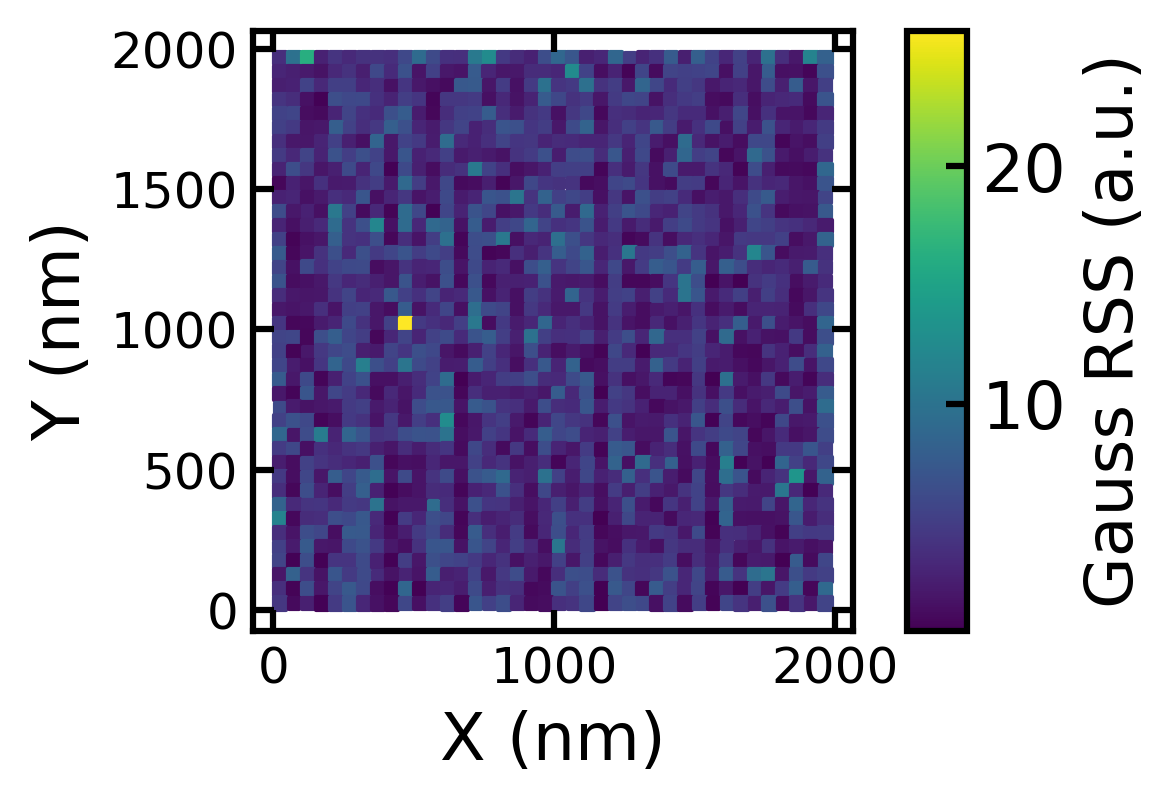

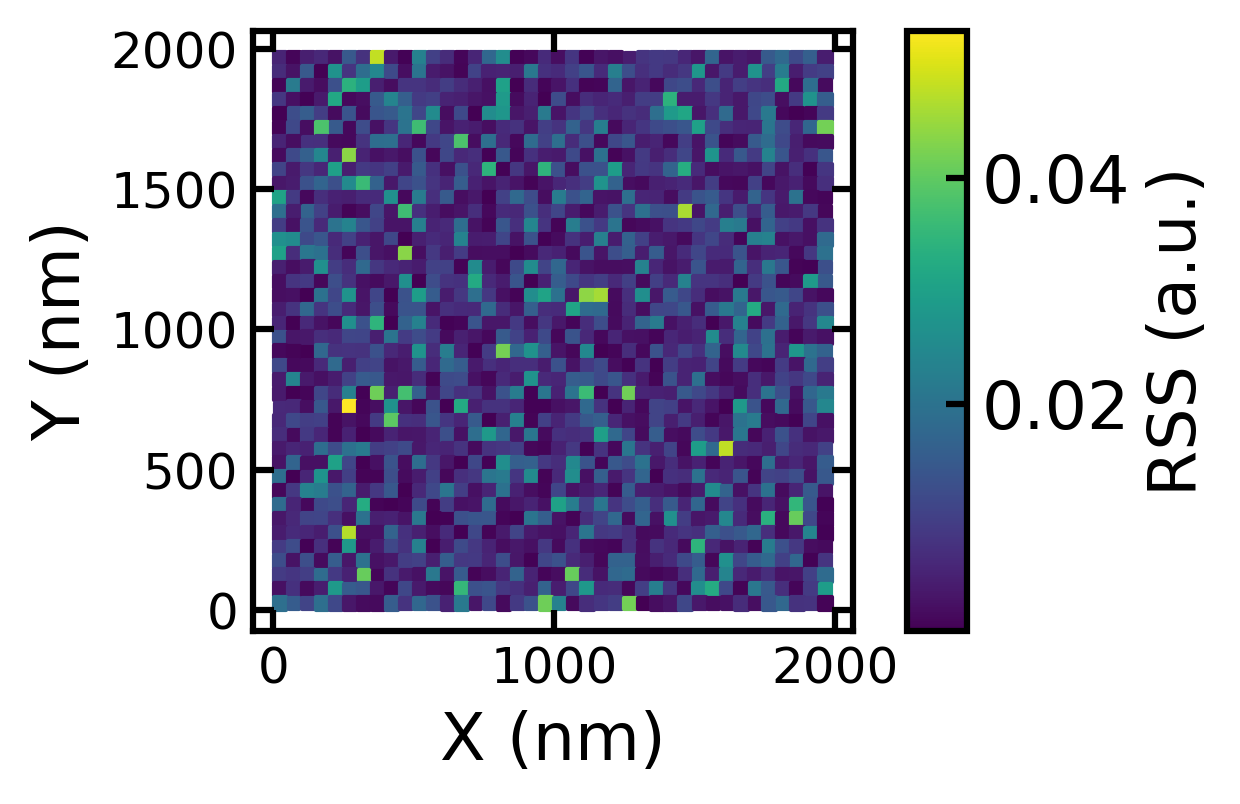

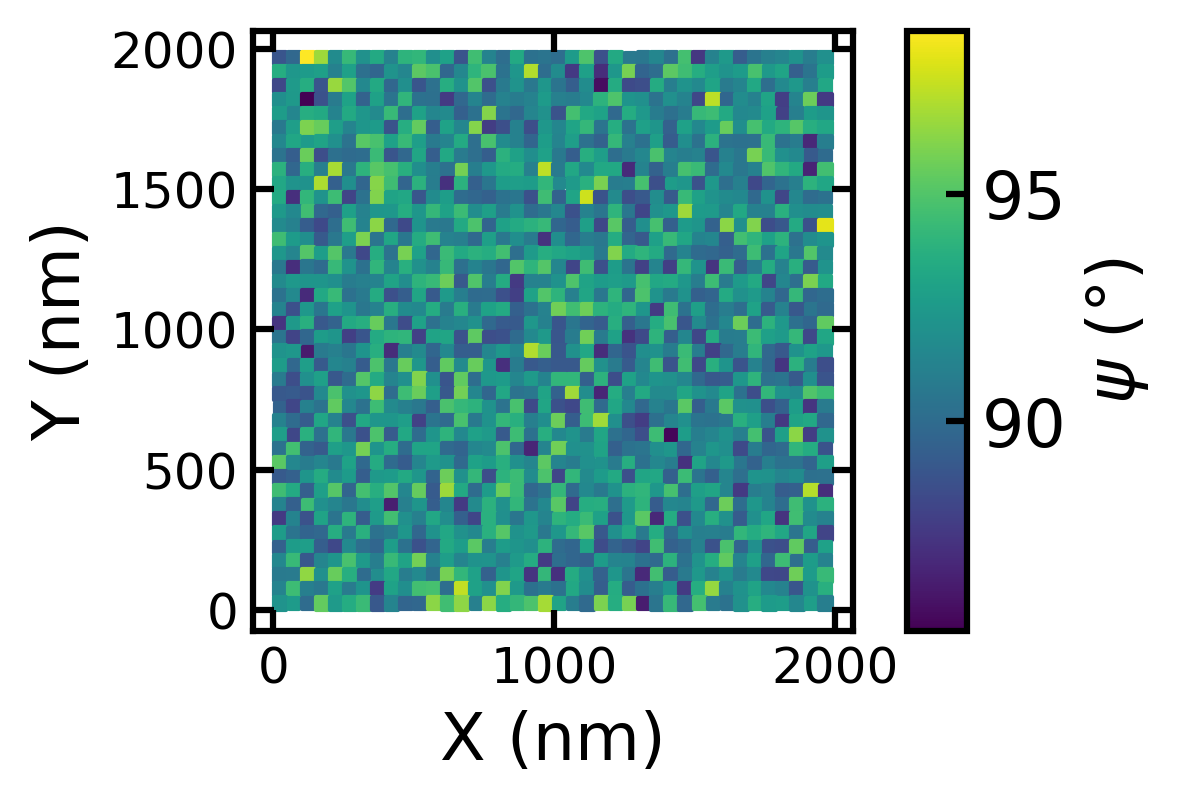

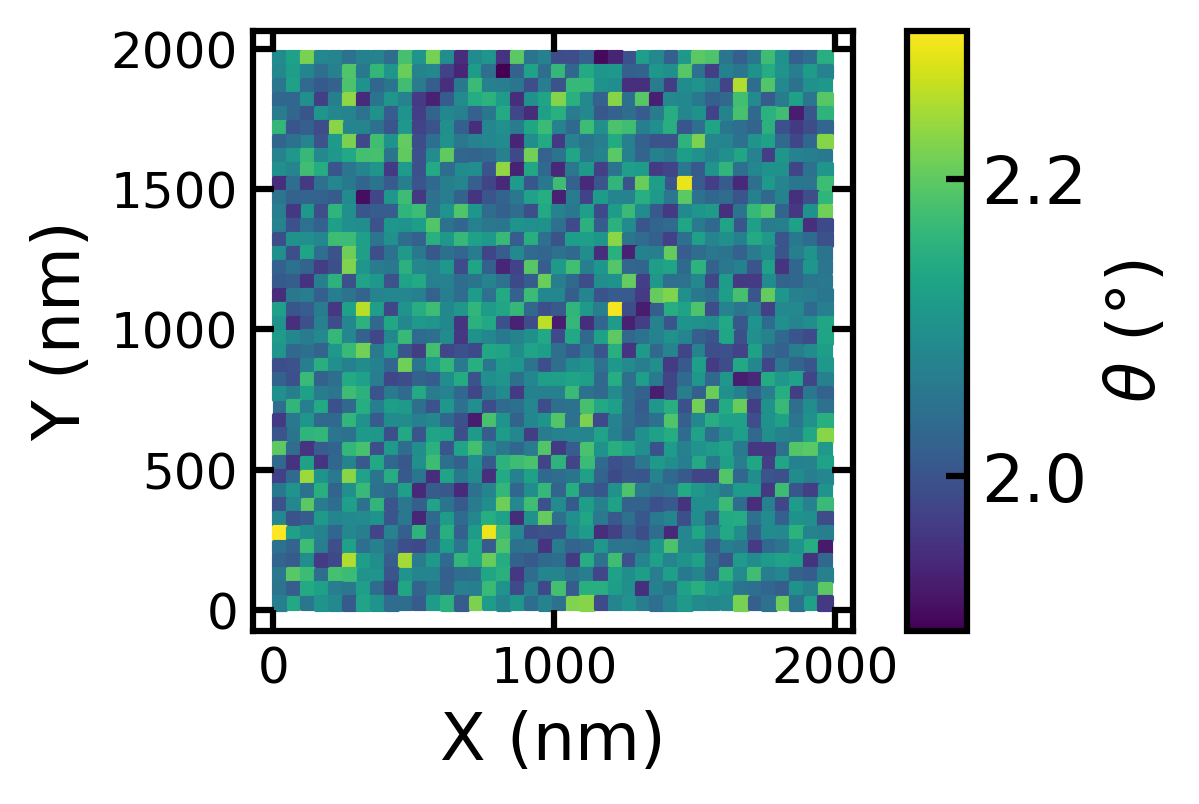

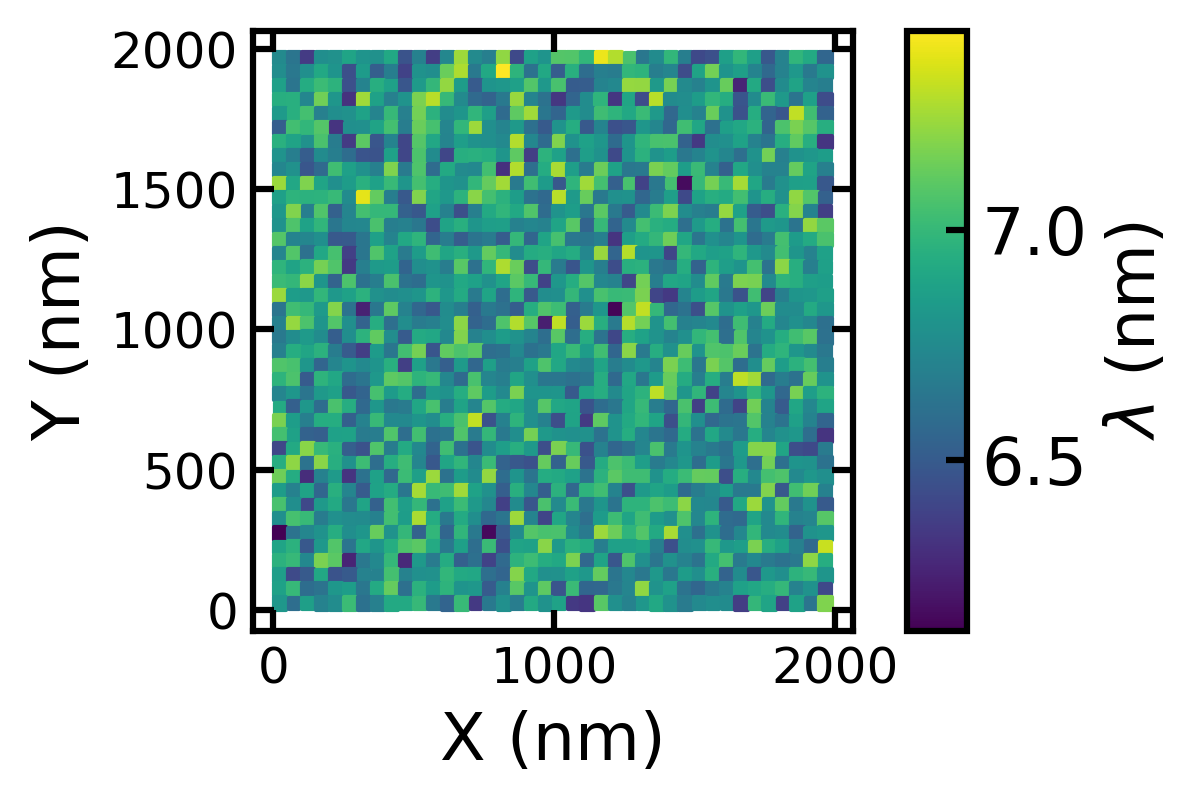

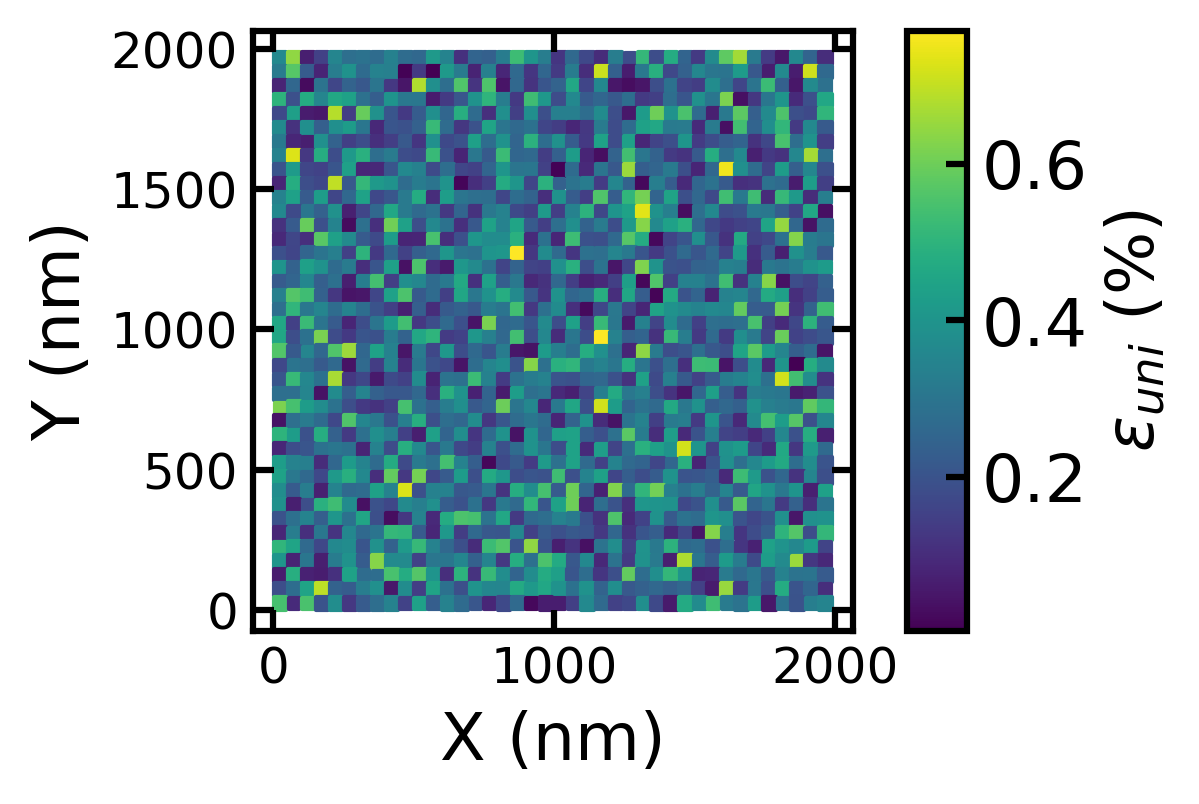

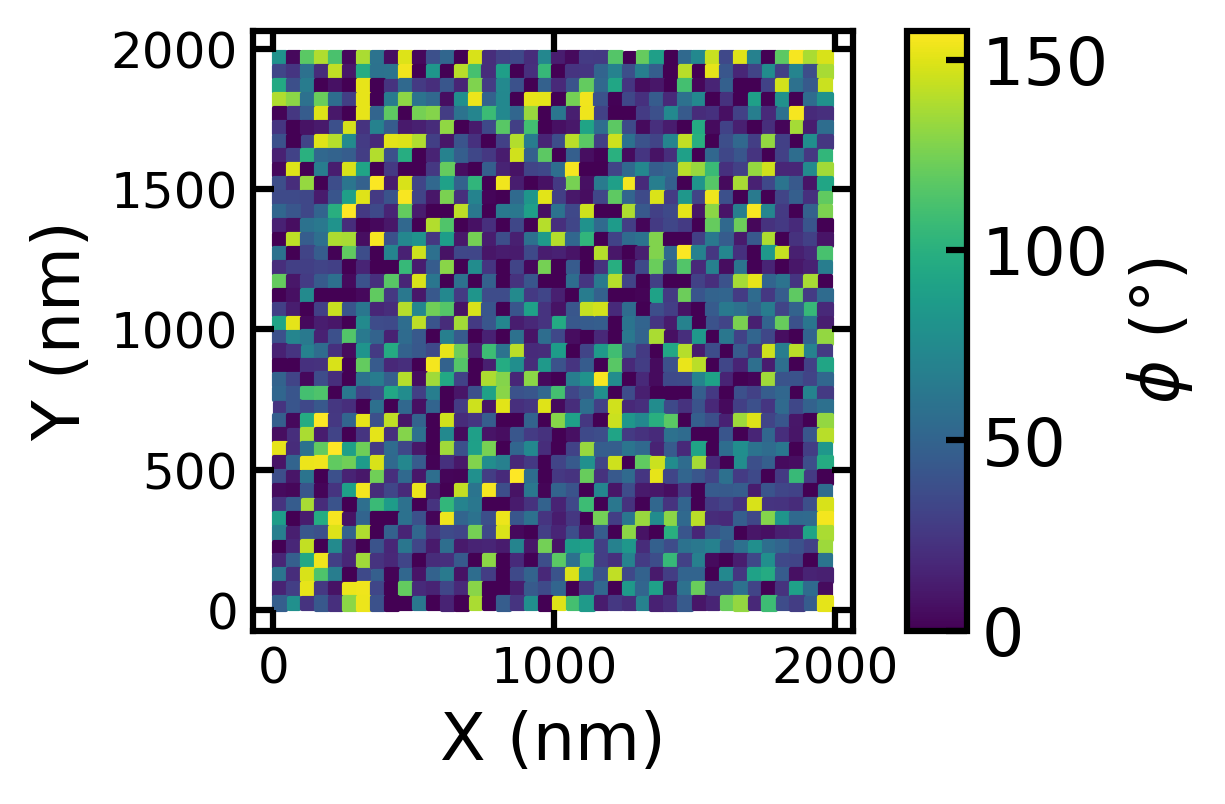

In [242]:
# RUN THIS FOR AVERAGING THE VECTORS
plt.close()

save = True

centers = np.zeros((ny, nx))
moire = {
    'gauss_rss' : centers.copy(),
    'rss': centers.copy(),
    'global_ang': centers.copy(),
    'twist': centers.copy(),
    'wavelength': centers.copy(),
    'strain': centers.copy(),
    'strain_ang': centers.copy(),
    'gg1': (centers.copy()).tolist(),
    'gg2': (centers.copy()).tolist(),
    'gg3': (centers.copy()).tolist(),
}

# ks = ['global_ang', 'twist', 'wavelength', 'strain', 'strain_ang']
# for k in ks:
#     moire[k] = (moire_up[k] + moire_down[k]) / 2
guess1 = guess
for i in range(len(moire_up['twist'])):
    for j in range(len(moire_up['twist'][0])):
        # average the detected peaks between the 
        g1 = (moire_up['gg1'][i][j] + moire_down['gg1'][i][j]) / 2
        g2 = (moire_up['gg2'][i][j] + moire_down['gg2'][i][j]) / 2
        g3 = (moire_up['gg3'][i][j] + moire_down['gg3'][i][j]) / 2


        fit_params, rss, gg1, gg2, gg3 = run_moire_fit(peaks=peaks, param_guess=guess1, ggs=[g1, g2, g3])

        guess1 = guess
        moire['global_ang'][i, j] = fit_params[0] * 180 / np.pi
        moire['twist'][i, j] = fit_params[1] * 180 / np.pi
        moire['wavelength'][i,j] = moire_wavelength(fit_params[1] * 180 / np.pi)
        moire['strain'][i, j] = fit_params[2] * 100
        moire['strain_ang'][i, j] = (fit_params[3] * 180 / np.pi) 
        moire['rss'][i, j] = rss
        moire['gg1'][i][j] = gg1
        moire['gg2'][i][j] = gg2
        moire['gg3'][i][j] = gg3


moire['gauss_rss'] = moire_up['gauss_rss'] + moire_down['gauss_rss']

# extract the spatial map for plotting
deltax_nm = deltax * pixel_size[0]
deltay_nm = deltay * pixel_size[1]
x_nm = np.array(np.arange(0.5, nx+0.5, 1) * deltax_nm, dtype=int)
y_nm = np.array(np.arange(0.5, ny+0.5, 1) * deltay_nm, dtype=int)
print(x_nm)
print(y_nm)
x_nm, y_nm = np.meshgrid(x_nm, y_nm)

# use the uncertainties to find the area of the point
moire['trust'] = 1 - ((moire['rss'] / np.amax(moire['rss']))*(moire['gauss_rss'] / np.amax(moire['gauss_rss'])))

print(np.amax(moire['trust']))
print(np.amin(moire['trust']))


lbls = {'gauss_rss': 'Gauss RSS (a.u.)',
        'rss': 'RSS (a.u.)',
        'global_ang': r'$\psi$ (°)',
        'twist': r'$\theta$ (°)',
        'strain': r'$\epsilon_{uni}$ (%)',
        'strain_ang': r'$\phi$ (°)',
        'wavelength': r'$\lambda$ (nm)',}


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def set_marker_size(nx, ny, fw, fh, f, ax=None):
    if not ax: ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    w = r - l
    h = t - b
    print(l, r, t, b, w, h)
    fig_dpi = fig.get_dpi()

    
# markersizes
# for fw, fh = 3*1.2, 3*1; nx, ny = 20, 20; s = 9.5
# for fw, fh = 3*1.2, 3*1; nx, ny = 10, 10; s = 20.3 13.2
# for fw, fh = 3*1.2, 3*1; nx, ny = 5, 5; s = 46
# for fw, fh = 3*1.2, 3*1; nx, ny = 4, 4; s = 62

x_nm = np.rot90(x_nm)
y_nm = np.rot90(y_nm)
save = True
for key, vals in moire.items():
    if not key in ['gg1', 'gg2', 'gg3', 'trust']:
        fig, ax = plt.subplots(figsize=(5*1.618, 5), dpi=300)
        ax.set_aspect('equal')
        fw, fh = 3*1.2, 2

        vals = np.rot90(vals)

        pc = ax.scatter(y_nm.ravel(), x_nm.ravel(), c=vals.ravel(), marker='s', s=((3*moire['trust'])**2).ravel(), cmap='viridis')
        fig.colorbar(pc, ax=ax, label=lbls[key], aspect=10)
        # plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        # plt.tick_params(axis='y', which='both', left=False, labelleft=False)
        ax.set_xlabel('X (nm)')
        ax.set_ylabel('Y (nm)')
        set_size(fw, fh)
        ax.tick_params(labelsize=12)
        # plt.tight_layout()
        if save:
            plt.savefig(f'{data_root}/{nx}_{ny}_{key}.png', dpi=300, bbox_inches='tight', transparent=True)
    # plt.close()




# Random code for random plots

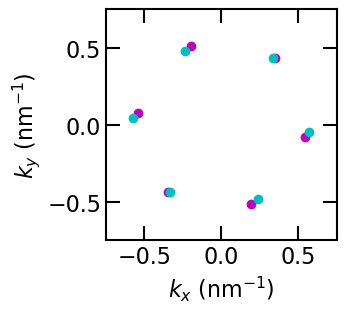

In [447]:
#### for plotting the before/after vecs for the gr/hBN moiré

aa = 0.246
ab = 0.2504
#print(aa**2)
delta = aa*(1/aa - 1/ab)
G1 = aa * np.array([[1], [0]]) 
G2 = aa * np.array([[-1/2], [np.sqrt(3)/2]])

BN1 = ab * np.array([[1], [0]]) 
BN2 = ab * np.array([[-1/2], [np.sqrt(3)/2]])

def R(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def S(eps, phi):
    return np.array([[1, 0], [0, 1]]) + (eps * R(phi).T @ np.array([[1, 0], [0, -0.16]]) @ R(phi))

def transformed_moire_vecs(t, theta, eps, phi):
    #transforming with twist and strain in real space
    G1_tr = R(theta) @ S(eps, phi) @ G1
    G2_tr = R(theta) @ S(eps, phi) @ G2
    BN1_tr = BN1
    BN2_tr = BN2

    #converting transformed vectors to reciprocal space
    #note that these are now 60° apart
    A = 2*np.pi/(G1_tr[0]*G2_tr[1] - G1_tr[1]*G2_tr[0])
    G1_rec = A * np.array([G2_tr[1], -G2_tr[0]])
    G2_rec = A * np.array([-G1_tr[1], G1_tr[0]])

    A_bn = 2*np.pi/(BN1_tr[0]*BN2_tr[1] - BN1_tr[1]*BN2_tr[0])
    BN1_rec = A_bn * np.array([BN2_tr[1], -BN2_tr[0]])
    BN2_rec = A_bn * np.array([-BN1_tr[1], BN1_tr[0]])

    #moire vectors in reciprocal space = difference of G and BN RLVs
    G_M1 = G1_rec - BN1_rec
    G_M2 = G2_rec - BN2_rec
    G_M3 = G_M2 - G_M1
    return [G_M1, G_M2, G_M3]


def transformed_moire_vecs_tbg(t, theta, eps, phi):
    #transforming with twist and strain in real space
    G1_tr = R(theta) @ S(eps, phi) @ G1
    G2_tr = R(theta) @ S(eps, phi) @ G2
    G1b_tr = G1
    G2b_tr = G2

    #converting transformed vectors to reciprocal space
    #note that these are now 60° apart
    A = 2*np.pi/(G1_tr[0]*G2_tr[1] - G1_tr[1]*G2_tr[0])
    G1_rec = A * np.array([G2_tr[1], -G2_tr[0]])
    G2_rec = A * np.array([-G1_tr[1], G1_tr[0]])

    A_bn = 2*np.pi/(G1b_tr[0]*G2b_tr[1] - G1b_tr[1]*G2b_tr[0])
    G1b_rec = A_bn * np.array([G2b_tr[1], -G2b_tr[0]])
    G2b_rec = A_bn * np.array([-G1b_tr[1], G1b_tr[0]])

    #moire vectors in reciprocal space = difference of G and BN RLVs
    G_M1 = G1_rec - G1b_rec
    G_M2 = G2_rec - G2b_rec
    G_M3 = G_M2 - G_M1
    return [G_M1, G_M2, G_M3]


# fit parameters from before and after stressor
# global angle (rad), interfacial twist (rad), strain, strain angle (rad)
before = (8.84*np.pi/180, 0.389*np.pi/180, 0.035/100, 43.24*np.pi/180)
after = (0.40*np.pi/180, 0.450*np.pi/180, 0.129/100, 100.24*np.pi/180)

before_vecs = transformed_moire_vecs(*before)
after_vecs = transformed_moire_vecs(*after)
xvec = np.linspace(-1, 1, 101)

# make the figure
fig, ax = plt.subplots()

# plot the before stressor peaks
for v in before_vecs:
    ax.plot(v[0], v[1], 'mo')
    ax.plot(-v[0], -v[1], 'mo')

# # plot the strain angle from the before stressor parameters
# strainang = before[-1]
# ax.plot(xvec, np.tan(strainang) * xvec, '--m')

# plot the after stressor peaks
for v in after_vecs:
    ax.plot(v[0], v[1], 'co')
    ax.plot(-v[0], -v[1], 'co')

# # plot the strain angle from the after stressor parameters
# strainang = after[-1]
# ax.plot(xvec, np.tan(strainang) * xvec, '--c')

ax.set_aspect('equal')
ax.set_xticks(np.arange(-1, 1, 0.5))
ax.set_yticks(np.arange(-1, 1, 0.5))
ax.tick_params(size=10)
lim = 0.75
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(r'$k_x$ ($\mathrm{nm^{-1}}$)')
ax.set_ylabel(r'$k_y$ ($\mathrm{nm^{-1}}$)')
fig.patch.set_alpha(0.)



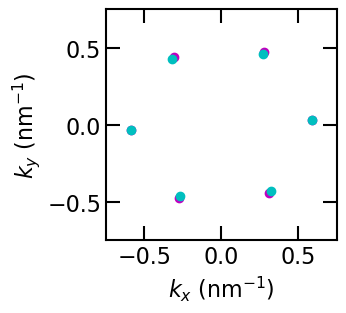

In [450]:
#### for plotting the before/after vecs for the gr/hBN moiré

aa = 0.246
ab = 0.2504
#print(aa**2)
delta = aa*(1/aa - 1/ab)
G1 = aa * np.array([[1], [0]]) 
G2 = aa * np.array([[-1/2], [np.sqrt(3)/2]])

BN1 = ab * np.array([[1], [0]]) 
BN2 = ab * np.array([[-1/2], [np.sqrt(3)/2]])

def R(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def S(eps, phi):
    return np.array([[1, 0], [0, 1]]) + (eps * R(phi).T @ np.array([[1, 0], [0, -0.16]]) @ R(phi))

def transformed_moire_vecs(t, theta, eps, phi):
    #transforming with twist and strain in real space
    G1_tr = R(theta) @ S(eps, phi) @ G1
    G2_tr = R(theta) @ S(eps, phi) @ G2
    G1b_tr = G1
    G2b_tr = G2

    #converting transformed vectors to reciprocal space
    #note that these are now 60° apart
    A = 2*np.pi/(G1_tr[0]*G2_tr[1] - G1_tr[1]*G2_tr[0])
    G1_rec = A * np.array([G2_tr[1], -G2_tr[0]])
    G2_rec = A * np.array([-G1_tr[1], G1_tr[0]])

    A_bn = 2*np.pi/(G1b_tr[0]*G2b_tr[1] - G1b_tr[1]*G2b_tr[0])
    G1b_rec = A_bn * np.array([G2b_tr[1], -G2b_tr[0]])
    G2b_rec = A_bn * np.array([-G1b_tr[1], G1b_tr[0]])

    #moire vectors in reciprocal space = difference of G and BN RLVs
    G_M1 = G1_rec - G1b_rec
    G_M2 = G2_rec - G2b_rec
    G_M3 = G_M2 - G_M1
    return [G_M1, G_M2, G_M3]


# fit parameters from before and after stressor
# global angle (rad), interfacial twist (rad), strain, strain angle (rad)
before = (117.14*np.pi/180, 1.086*np.pi/180, 0.167/100, 129.98*np.pi/180)
after = (114.56*np.pi/180, 1.076*np.pi/180, 0.216/100, 134.52*np.pi/180)

before_vecs = transformed_moire_vecs(*before)
after_vecs = transformed_moire_vecs(*after)
xvec = np.linspace(-1, 1, 101)

# make the figure
fig, ax = plt.subplots()

# plot the before stressor peaks
for v in before_vecs:
    ax.plot(v[0], v[1], 'mo')
    ax.plot(-v[0], -v[1], 'mo')

# # plot the strain angle from the before stressor parameters
# strainang = before[-1]
# ax.plot(xvec, np.tan(strainang) * xvec, '--m')

# plot the after stressor peaks
for v in after_vecs:
    ax.plot(v[0], v[1], 'co')
    ax.plot(-v[0], -v[1], 'co')

# # plot the strain angle from the after stressor parameters
# strainang = after[-1]
# ax.plot(xvec, np.tan(strainang) * xvec, '--c')

ax.set_aspect('equal')
ax.set_xticks(np.arange(-1, 1, 0.5))
ax.set_yticks(np.arange(-1, 1, 0.5))
ax.tick_params(size=10)
lim = 0.75
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(r'$k_x$ ($\mathrm{nm^{-1}}$)')
ax.set_ylabel(r'$k_y$ ($\mathrm{nm^{-1}}$)')
fig.patch.set_alpha(0.)

